In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

import itertools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.selection import DropDuplicateFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from optbinning import BinningProcess, OptimalBinning

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector as SFS

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, log_loss

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss

import optuna

import warnings
warnings.simplefilter('ignore')    # ignore warnings

(CVXPY) Oct 26 10:26:27 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 26 10:26:27 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


/home/mai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Load data

For our analysis, we will use the training dataset located at `./data/train.csv`

This Dataset is the training dataset in a Hackathon organized by Deloitte. The aim is to predict whether a person will be a loan defaulter or not by looking at various attributes like funded amount, location, loan, balance, etc. In reality, banks and finance institutions would create credit scorecards for such tasks and rank their customers by credit score.

In first sections of this notebook, we will focus on feature engineering to extract and prepare our dataset for a classifier algorithm. At the end, we will use the engineered features to fit a classifier.

In [3]:
df = pd.read_csv('./data/train.csv')

df.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


Brief description of columns:

- `ID`: unique ID of representative
- `Loan Amount`: loan amount applied
- `Funded Amount`: loan amount funded
- `Funded Amount Investor`: loan amount approved by the investors
- `Term`: term of loan (in months)
- `Batch Enrolled`: batch numbers to representatives
- `Interest Rate`: interest rate (%) on loan
- `Grade`: grade by the bank
- `Sub Grade`: sub-grade by the bank
- `Employment Duration`: duration
- `Home Ownership`: Ownership of home
- `Verification Status`: Income verification by the bank
- `Payment Plan`: if any payment plan has started against loan
- `Loan Title`: loan title provided
- `Debit to Income`: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
- `Delinquency - two years`: number of 30+ days delinquency in past 2 years
- `Inquiries - six months`: total number of inquiries in last 6 months
- `Open Account`: number of open credit line in representative's credit line
- `Public Records`: number of derogatory public records
- `Revolving Balance`: total credit revolving balance
- `Revolving Utilities`: amount of credit a representative is using relative to Revolving Balance
- `Total Accounts`: total number of credit lines available in representative's credit lines
- `Initial List Status`: unique listing status of the loan - W(Waiting), F(Forwarded)
- `Total Received Interest`: total interest received till date
- `Total Received Late Fee`: total late fee received till date
- `Recoveries`: post charge off gross recovery
- `Collection Recovery Fee`: post charge off collection fee
- `Collection 12 months Medical`: total collections in last 12 months excluding medical collections
- `Application Type`: indicates when the representative is an individual or joint
- `Last week Pay`: indicates how long (in weeks) a representative has paid EMI after batch enrolled
- `Accounts Delinquent`: number of accounts on which the representative is delinquent
- `Total Collection Amount`: total collection amount ever owed
- `Total Current Balance`: total current balance from all accounts
- `Total Revolving Credit Limit`: total revolving credit limit
- `Loan Status`: 1 = Defaulter, 0 = Non-defaulter

First, it seems like the data in `Employment Duration` should have been `Home Ownership`. We are not sure what the data in `Home Ownership` would have been, but one possibility is income. So let's rename `Home Ownership` to `Income`

In [4]:
df = df.rename(columns={'Home Ownership': 'Income', 'Employment Duration': 'Home Ownership'})

In [5]:
# let's also convert the column names to lowercase snake case 
col_names_new = [var.lower().replace('- ', '').replace(' ', '_') for var in df.columns]
df.columns = col_names_new

df.head(10)

,id,loan_amount,funded_amount,funded_amount_investor,term,batch_enrolled,interest_rate,grade,sub_grade,home_ownership,income,verification_status,payment_plan,loan_title,debit_to_income,delinquency_two_years,inquires_six_months,open_account,public_record,revolving_balance,revolving_utilities,total_accounts,initial_list_status,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,collection_12_months_medical,application_type,last_week_pay,accounts_delinquent,total_collection_amount,total_current_balance,total_revolving_credit_limit,loan_status
0,65087372,10000,32236,12329.362860,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.996920,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.224550,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.155850,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.926670,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0
5,50509046,34631,30203,8635.931613,36,BAT4694572,17.246986,B,G5,RENT,98957.47561,Not Verified,n,Credit card refinancing,7.914333,3,2,16,0,2277,51.564476,20,w,464.818124,0.088584,5.043575,0.581688,0,INDIVIDUAL,32,0,42,51252,27480,0
6,32737431,30844,19773,15777.511830,59,BAT4808022,10.731432,C,C5,RENT,102391.82430,Verified,n,Home improvement,15.083911,0,0,11,0,14501,46.808804,37,w,525.738109,0.083528,3.167937,0.553076,0,INDIVIDUAL,71,0,3388,42069,31068,0
7,63151650,20744,10609,7645.014802,58,BAT2558388,13.993688,A,A5,OWN,61723.52014,Not Verified,n,Debt consolidation,29.829715,0,0,14,0,13067,23.936624,33,w,1350.245212,0.044965,0.098448,0.047589,0,INDIVIDUAL,87,0,48,184909,43303,0
8,4279662,9299,11238,13429.456610,59,BAT5341619,11.178457,G,C2,MORTGAGE,63205.09072,Verified,n,Credit card refinancing,26.244710,0,0,6,0,549,15.947386,17,w,4140.198978,0.017106,0.530214,0.216985,0,INDIVIDUAL,144,0,26,68126,7482,0
9,4431034,19232,8962,7004.097481,58,BAT2078974,5.520413,C,B5,RENT,42015.46586,Source Verified,n,Credit card refinancing,10.048549,1,0,11,0,1361,35.073345,30,f,2149.666963,0.008338,2.912215,0.886864,0,INDIVIDUAL,9,0,35,71650,14871,0


In [6]:
# check the number of rows and columns
df.shape

(67463, 35)

In [7]:
# Displays column names, complete (non-missing) cases per column, and datatype per column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            67463 non-null  int64  
 1   loan_amount                   67463 non-null  int64  
 2   funded_amount                 67463 non-null  int64  
 3   funded_amount_investor        67463 non-null  float64
 4   term                          67463 non-null  int64  
 5   batch_enrolled                67463 non-null  object 
 6   interest_rate                 67463 non-null  float64
 7   grade                         67463 non-null  object 
 8   sub_grade                     67463 non-null  object 
 9   home_ownership                67463 non-null  object 
 10  income                        67463 non-null  float64
 11  verification_status           67463 non-null  object 
 12  payment_plan                  67463 non-null  object 
 13  l

In [8]:
# get some descriptive statistics
# for categorical features, we will also see the number of unique values
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,67463.0,NaN,NaN,NaN,25627607.746498,21091554.023733,1297933.0,6570288.0,17915646.0,42715208.5,72245779.0
loan_amount,67463.0,NaN,NaN,NaN,16848.902776,8367.865726,1014.0,10012.0,16073.0,22106.0,35000.0
funded_amount,67463.0,NaN,NaN,NaN,15770.599114,8150.992662,1014.0,9266.5,13042.0,21793.0,34999.0
funded_amount_investor,67463.0,NaN,NaN,NaN,14621.799323,6785.34517,1114.590204,9831.684984,12793.68217,17807.59412,34999.74643
term,67463.0,NaN,NaN,NaN,58.173814,3.327441,36.0,58.0,59.0,59.0,59.0
batch_enrolled,67463,41,BAT3873588,3626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interest_rate,67463.0,NaN,NaN,NaN,11.846258,3.718629,5.320006,9.297147,11.377696,14.193533,27.182348
grade,67463,7,C,19085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,67463,35,B4,4462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,67463,3,MORTGAGE,36351,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# let's separate the data into target and features
target = 'loan_status'

y = df[target]
X = df[[col for col in df.columns if col not in [target, 'id']]]

In [10]:
X.shape, y.shape

((67463, 33), (67463,))

## 2. Extract more features from the existing features

Based on the features' description, we can extract some more features from the existing ones.

In [11]:
# Group 1: features related to loan amount, funded, and funded investor amount
# total funded and funded investor
X['funded_sum'] = X['funded_amount'] + X['funded_amount_investor']
# loan amount to funded amount ratio
X['loan_to_funded'] = X['loan_amount'] / X['funded_amount']
# loan amount to funded investor ratio
X['loan_to_funded_investor'] = X['loan_amount'] / X['funded_amount_investor']
# funded to funded investor ratio
X['funded_to_funded_investor'] = X['funded_amount'] / X['funded_amount_investor']

In [12]:
# Group 2: interest rate, debit to income and income
# income to interest rate 
X['income_to_interest'] = X['income'] / X['interest_rate']
# interest rate to debit to income
X['interest_to_debit'] = X['interest_rate'] / X['debit_to_income']

In [13]:
# Group 3: delinquencies, public record, open account
# any inquries in last six months
X['any_inquires_six_months'] = (X['inquires_six_months'] > 0).astype(int)
# any delinquency last 2 years
X['any_delinquency_two_years'] = (X['delinquency_two_years'] > 0).astype(int)
# any collections in last 12 months excluding medical collections
X['any_collection_12_months_medical'] = (X['collection_12_months_medical'] > 0).astype(int)
# any public derogatory records
X['any_public_record'] = (X['public_record'] > 0).astype(int)

# delinquency per open account
X['deliquencies_per_open_account'] = X['delinquency_two_years'] / X['open_account']
# inquires per open account
X['inquires_per_open_account'] = X['inquires_six_months'] / X['open_account']
# public records per open account
X['records_per_open_account'] = X['public_record'] / X['open_account']

In [14]:
# Group 4: revolving balance and utilities
# revolving balance  * revolving utilities
X['revolving_balance_utilities_prod'] = X['revolving_balance'] * X['revolving_utilities']

In [15]:
# Group 5: open account and total accounts
X['open_account_to_total_account'] = X['open_account'] / X['total_accounts']
X['open_account_total_account_diff'] = X['total_accounts'] - X['open_account']

In [16]:
# Group 6: received interest, late fee, total accounts
X['received_interest_per_account'] = X['total_received_interest'] / X['total_accounts']
X['received_late_fee_per_account'] = X['total_received_late_fee'] / X['total_accounts']

In [17]:
# Group 7: recovereies, collection fee
X['recoveries_collection_fee_total'] = X['recoveries'] + X['collection_recovery_fee']
X['recoveries_collection_fee_prod'] = X['recoveries'] * X['collection_recovery_fee']

In [18]:
# Group 8: last week pay, total amount balance, credit limit
X['collection_amount_per_weekpay'] = X['total_collection_amount'] / X['last_week_pay']
X['collection_amount_weekday_prod'] = X['total_collection_amount'] * X['last_week_pay']
X['current_balance_revolving_credit_limit_total'] = X['total_current_balance'] + X['total_revolving_credit_limit']
X['current_balance_to_revolving_credit_limit'] = X['total_current_balance'] / X['total_revolving_credit_limit']

In [19]:
# Modify some features
# sub grade (extract the number part only)
X['sub_grade'] = X['sub_grade'].apply(lambda x: x[-1]).astype(int)
# batch number (extract the number part only)
X['batch_enrolled'] = X['batch_enrolled'].apply(lambda x: x[3:]).astype(int)

In [20]:
X.shape, y.shape

((67463, 57), (67463,))

## 3. Drop constant, quasi-constant, and duplicate variables

Next, let's identify constant and quasi-constant variables in our dataset using a variance threshold. Variables that have lower variance than this threshold will be considered a (quasi)constant variable and will be dropped from the analysis as they will not add any useful information towards whether a person is a defaulter.

We can use `sklearn.feature_selection.VarianceThreshold` to drop features with variance below a certain threshold, but the method is only applicable to numeric variables. If we want to apply the variance threshold method on non-numeric variables, we have to code it ourselves.

In [21]:
class DropQuasiConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, predominant_threshold=0.998):
        self.predominant_threshold = predominant_threshold
        # create an empty list to store quasi-constant features
        self.quasi_constant_features = []
        
    def fit(self, X, y=None):
        for feature in X.columns:
            # find the predominant value (shared by most observations):
            predominant = X[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
            # evaluate the predominant value frequency: does it exceed the threshold?
            if predominant > self.predominant_threshold:
                # if yes, add the feature to the list
                self.quasi_constant_features.append(feature)

        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.drop(self.quasi_constant_features, axis=1, inplace=True)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [22]:
drop_quasi_constant = DropQuasiConstantFeatures()
# we use the fit method to get the list of quasi-constant variables
quasi_constant_vars = drop_quasi_constant.fit(X).quasi_constant_features

print('Quasi-constant variables:', quasi_constant_vars)

Quasi-constant variables: ['payment_plan', 'application_type', 'accounts_delinquent']


In [23]:
# let's drop these variables
X = drop_quasi_constant.transform(X)

# check the number of variables after dropping quasi-constant variables
print(X.shape)

(67463, 54)


Let's also check if our dataset contains any duplicated variables, that is, features with different names but are identical in values. Since there is not built-in method for detecting and removing duplicated variables in pandas or sklearn, we'll use a different open-source package `feature_engine` to accomplish this.

In [24]:
# set up a selector using feature_engine.selection.DropDuplicateFeatures
drop_duplicate = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features
drop_duplicate.fit(X)

# let's check if there are any pairs of duplicated features
drop_duplicate.duplicated_feature_sets_

[{'any_collection_12_months_medical', 'collection_12_months_medical'}]

Looks like the binary variable we engineered from `collection_12_months_medical` is duplicated with the original variable itself because there are only 2 distinct values in this variable (0 or 1). So we'll use the binary variable we created instead.

In [25]:
X.drop('collection_12_months_medical', axis=1, inplace=True)

We can split our remaining variables into discrete / categorical variables and continuous variables.

In [26]:
discrete_vars = [var for var in X.columns if var not in quasi_constant_vars and X[var].dtype=='object' or X[var].nunique() < 100]
continuous_vars = [var for var in X.columns if var not in quasi_constant_vars and var not in discrete_vars]

# let's check out the number of categorical variables and numerical variables
print('Number of discrete variables:', len(discrete_vars))
print('Number of continuous variables:', len(continuous_vars))

Number of discrete variables: 20
Number of continuous variables: 33


## 4. Target variable - Loan Status

Let's inspect the target variable - `Loan Status`. This is a binary variable, with `0` = Non-defaulter and `1` = Defaulter.


In [27]:
# the overall default rate
default_perc = sum(y) / y.shape[0]

print(f'The overall default rate is: {default_perc:.4f}')

The overall default rate is: 0.0925


Our dataset is highly imbalanced. The ratio of Non-defaulters to Defaulters is roughly 10:1

## 5. Discrete variables

### 5.1. Quick inspection

Let's check out the list of categorical variables and how many unique categories each of them contains.

In [28]:
X[discrete_vars].nunique().sort_values()

any_public_record                     2
any_collection_12_months_medical      2
any_delinquency_two_years             2
any_inquires_six_months               2
initial_list_status                   2
term                                  3
home_ownership                        3
verification_status                   3
sub_grade                             5
public_record                         5
inquires_six_months                   6
grade                                 7
delinquency_two_years                 9
open_account                         36
batch_enrolled                       41
total_accounts                       69
records_per_open_account             79
inquires_per_open_account            89
open_account_total_account_diff      96
loan_title                          109
dtype: int64

We notice that these variables can be divided into 3 groups:  binary variables, ordinal variables, and nominal variables

In [29]:
# let's define our groups of variables here
binary_variables = [var for var in discrete_vars if X[var].nunique() == 2]
ordinal_variables = ['grade', 'sub_grade', 'public_record', 'inquires_six_months', 'delinquency_two_years', 'open_account',
                    'total_accounts', 'records_per_open_account', 'inquires_per_open_account', 'open_account_total_account_diff']
nominal_variables = [var for var in discrete_vars if var not in binary_variables and var not in ordinal_variables]

### 5.2. Some data cleaning

Some variables are high-cardinality - `loan_title`. In particular, the inconsistent values in `Loan Title` are likely the result of manual data entry. To properly analyze the data in this variable, we need to clean it.

In [30]:
class LoanTitleCleanUp(BaseEstimator, TransformerMixin):
    def __init__(self, feature='loan_title', rare_threshold=0.01):
        self.feature = feature
        self.rare_threshold = rare_threshold
        
    def fit(self, X, y=None):
        self.mapping = {
            'consolidation loan': 'debt consolidation',
            'debt consolidation loan': 'debt consolidation',
            'consolidation': 'debt consolidation',
            'loan': 'other',
            'credit card debt': 'credit card',
            'credit card loan': 'credit card',
            'debt loan': 'other',
            'credit cards': 'credit card',
            'cards': 'credit card',
            'credit consolidation': 'credit card consolidation',
            'credit card refi': 'credit card refinancing',
            'credit card refinance': 'credit card refinancing',
            'debt free': 'debt payoff',
            'bathroom': 'home improvement',
            'dept consolidation': 'debt consolidation',
            'credit cardrefinance': 'credit card refinancing',
            'get out of debt': 'debt payoff',
            'credit loan': 'credit card',
            'car loan': 'major purchase',
            'car financing': 'major purchase',
            'loan consolidation': 'debt consolidation',
            'credit card refinance loan': 'credit card refinancing',
            'credit': 'credit card'
        }
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        # first, let's convert the values to lower case, remove leading spaces, and remove any special characters
        X_transformed[self.feature] = X[self.feature].str.lower().str.lstrip().str.replace(r'[^a-z\s]', '', regex=True).str.strip()
        # replace synonyms
        X_transformed[self.feature] = X_transformed[self.feature].str.replace('cc', 'credit card')\
                                    .str.replace('cc', 'credit card')\
                                    .str.replace('consolidate', 'consolidation')\
                                    .apply(lambda x: 'medical expenses' if 'medical' in x else x)\
                                    .apply(lambda x: 'home improvement' if 'home' in x else x)\
                                    .apply(lambda x: 'bill payments' if 'bill' in x else x)

        # apply the mapping
        X_transformed[self.feature] = X_transformed[self.feature].replace(self.mapping)

        # Handle rare categories
        frequencies = X_transformed[self.feature].value_counts(normalize=True)
        X_transformed[self.feature] = X_transformed[self.feature].apply(lambda x: 'other' if frequencies[x] < self.rare_threshold else x)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [31]:
# test the transformer - we want to set up a pipeline that can be reused later so for now, we will not overwrite X with our fit & transform method
loan_title_clean = LoanTitleCleanUp('loan_title', 0.001)

### 5.3. Variable Encoding

One encoding method typically used in credit scoring is Weight of Evidence, which quantifies the relationship between a category of a variable and a binary target. In other words, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). In doing so, it also creates a monotonic relationships between the encoded variable and the target, which works better with our linear models.

The formula for calculting WoE for a category within a variable is as follows:

$$WOE = ln(\frac {\text{Distribution of events}} {\text{Distribution of non-events}})$$

WoE is especially well suited for linear models like Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

Let's create a custom transformer that will apply WoE encoding to our variables.

In [32]:
class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.woe_dict = {}
        
    def fit(self, X, y):
        X_ = X.copy()
        X_['target'] = y
        for var in X.columns:
            # calculate event and non-event prob
            event_prob = X_.groupby(var)['target'].mean()
            non_event_prob = 1 - event_prob
            # calculate woe, handling division by 0 with np.log(1e-6)
            self.woe_dict[var] = np.log((event_prob + 1e-6) / (non_event_prob + 1e-6)).to_dict()

        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X_transformed[var].map(self.woe_dict[var]).fillna(0)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

#### 5.2.1. Binary variables

Let's create a WoE transformer for our binary variables using the transformer we just created. To apply it on our list of binary variables, we can wrap it in an instance of ColumnTransformer. The other variables will be passed through without modification.

In [33]:
binary_enc = ColumnTransformer(
    transformers=[
        ('binary_enc', WoEEncoder(), binary_variables)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

#### 5.2.2. Ordinal Variables
Next, let's tackle the ordinal variables. For these variables, it makes sense to replace the string labels with integer representation that captures the order of the values.

In [34]:
ordinal_variables

['grade',
 'sub_grade',
 'public_record',
 'inquires_six_months',
 'delinquency_two_years',
 'open_account',
 'total_accounts',
 'records_per_open_account',
 'inquires_per_open_account',
 'open_account_total_account_diff']

In [35]:
class OrdinalLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X, y=None):
        for var in X.columns:
            mapping = {k:i for i,k in enumerate(sorted(X[var].unique()), 0)}
            self.mappings[var] = mapping
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            mapping = self.mappings[var]
            X_transformed[var] = X[var].map(mapping)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [36]:
# create Custom Ordinal Encoder for ordinal variables, we'll also wrap it inside a column transformer
ordinal_label_enc = ColumnTransformer(
    transformers=[
        ('ordinal_label_enc', OrdinalLabelEncoder(), ['grade'])     # we only need to apply this to grade since other variables are already of type integer
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

Before we can apply Weight of Evidence transformation on these variables, we'll further group them up to: 1) handle rare categories and 2) ensure that the event rate for each group follows a monotonic trend. To do that, we will use the `OptimalBinning` transformer from an external library called `optbinning`. 

`OptimalBinning` also provides options to transform the binned variables using Weight of Evidence, event rate, or information value. So we'll make use of this functionality when we create our custom transformer below.

In [37]:
class OptBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, dtype='categorical', solver='cp', monotonic_trend='auto', 
                 user_splits=None, user_splits_fixed=None, transform_metric='woe'):
        self.features = features
        self.dtype = dtype
        self.solver = solver
        self.monotonic_trend = monotonic_trend
        self.user_splits = user_splits or {}
        self.user_splits_fixed = user_splits_fixed or {}
        self.transform_metric = transform_metric
        self.bin_models = {}

    # here we overwrite the fit method with our own fit method using OptimalBinning 
    def fit(self, X, y):
        for feature in self.features:
            # check if user splits for this feature is defined
            user_splits_ = self.user_splits.get(feature)
            user_splits_fixed_ = self.user_splits_fixed.get(feature)
            optb = OptimalBinning(name=feature, dtype=self.dtype, 
                                  user_splits=user_splits_, user_splits_fixed=user_splits_fixed_,
                                  solver=self.solver, monotonic_trend=self.monotonic_trend,)
            optb.fit(X[feature], y)
            if len(optb.splits) > 0:                # check if the binning results in splits, if yes
                self.bin_models[feature] = optb     # save this to the transformer's bin models for access later in transformation
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            if self.bin_models.get(feature):
                optb = self.bin_models.get(feature)
                X_transformed[feature] = optb.transform(X[feature], metric=self.transform_metric)    # use empirical WoE to transform missing values
        return X_transformed

In [38]:
# define specific user split for `inquires_six_months`
user_splits = {
    'inquires_six_months': [0.5]
}

user_splits_fixed = {
    'inquires_six_months': [True]
}

# create the transformer for these feature
ordinal_enc = OptBinningTransformer(features=ordinal_variables,
                                        dtype='numerical',            # dtype is numerical for ordinal variables
                                        solver='cp',
                                        monotonic_trend='auto',       # chooses the monotonic trend most likely to maximize the information value
                                        user_splits=user_splits,
                                        user_splits_fixed=user_splits_fixed,
                                       transform_metric='woe')

#### 5.2.3. Nominal variables

In [39]:
nominal_variables

['term',
 'batch_enrolled',
 'home_ownership',
 'verification_status',
 'loan_title']

In [40]:
# for the remaining nominal and binary features, we'll also apply OptBinningWoE transformer,
# but instead of setting the dtype to 'numerical', we'll set it to 'categorical'

# manually define custom splits for Loan Title
user_splits = {
    'loan_title': np.array([
        ['debt consolidation'],
        ['credit card refinancing'],
        ['credit card consolidation', 'credit card', 'payoff', 'personal loan', 'medical expenses', 'other'],
        ['home improvement', 'major purchase', 'moving and relocation', 'vacation', 'business']
    ], dtype=object)
}

user_splits_fixed = {
    'loan_title': [True, True, True, True]
}

# create the transformer for these feature
nominal_enc = OptBinningTransformer(features=nominal_variables,
                                         dtype='categorical',            # dtype is categorical for nominal variables
                                         solver='cp',
                                         monotonic_trend='auto',
                                         user_splits=user_splits,
                                         user_splits_fixed=user_splits_fixed,
                                       transform_metric='event_rate')

### 5.4. Preprocessing pipeline for discrete variables

In [44]:
# Create the pipeline for discrete variables, we'll do the fit and transform later
discrete_pipeline = Pipeline(steps=[
    ('loan_title_clean', loan_title_clean),
    ('binary_enc', binary_enc),
    ('ordinal_label_enc', ordinal_label_enc),
    ('ordinal_enc', ordinal_enc),
    ('nominal_enc', nominal_enc)
])

## 6. Continuous variables

### 6.1. Quick inspection
Let's take a look at our continuous variables

In [47]:
len(continuous_vars)

33

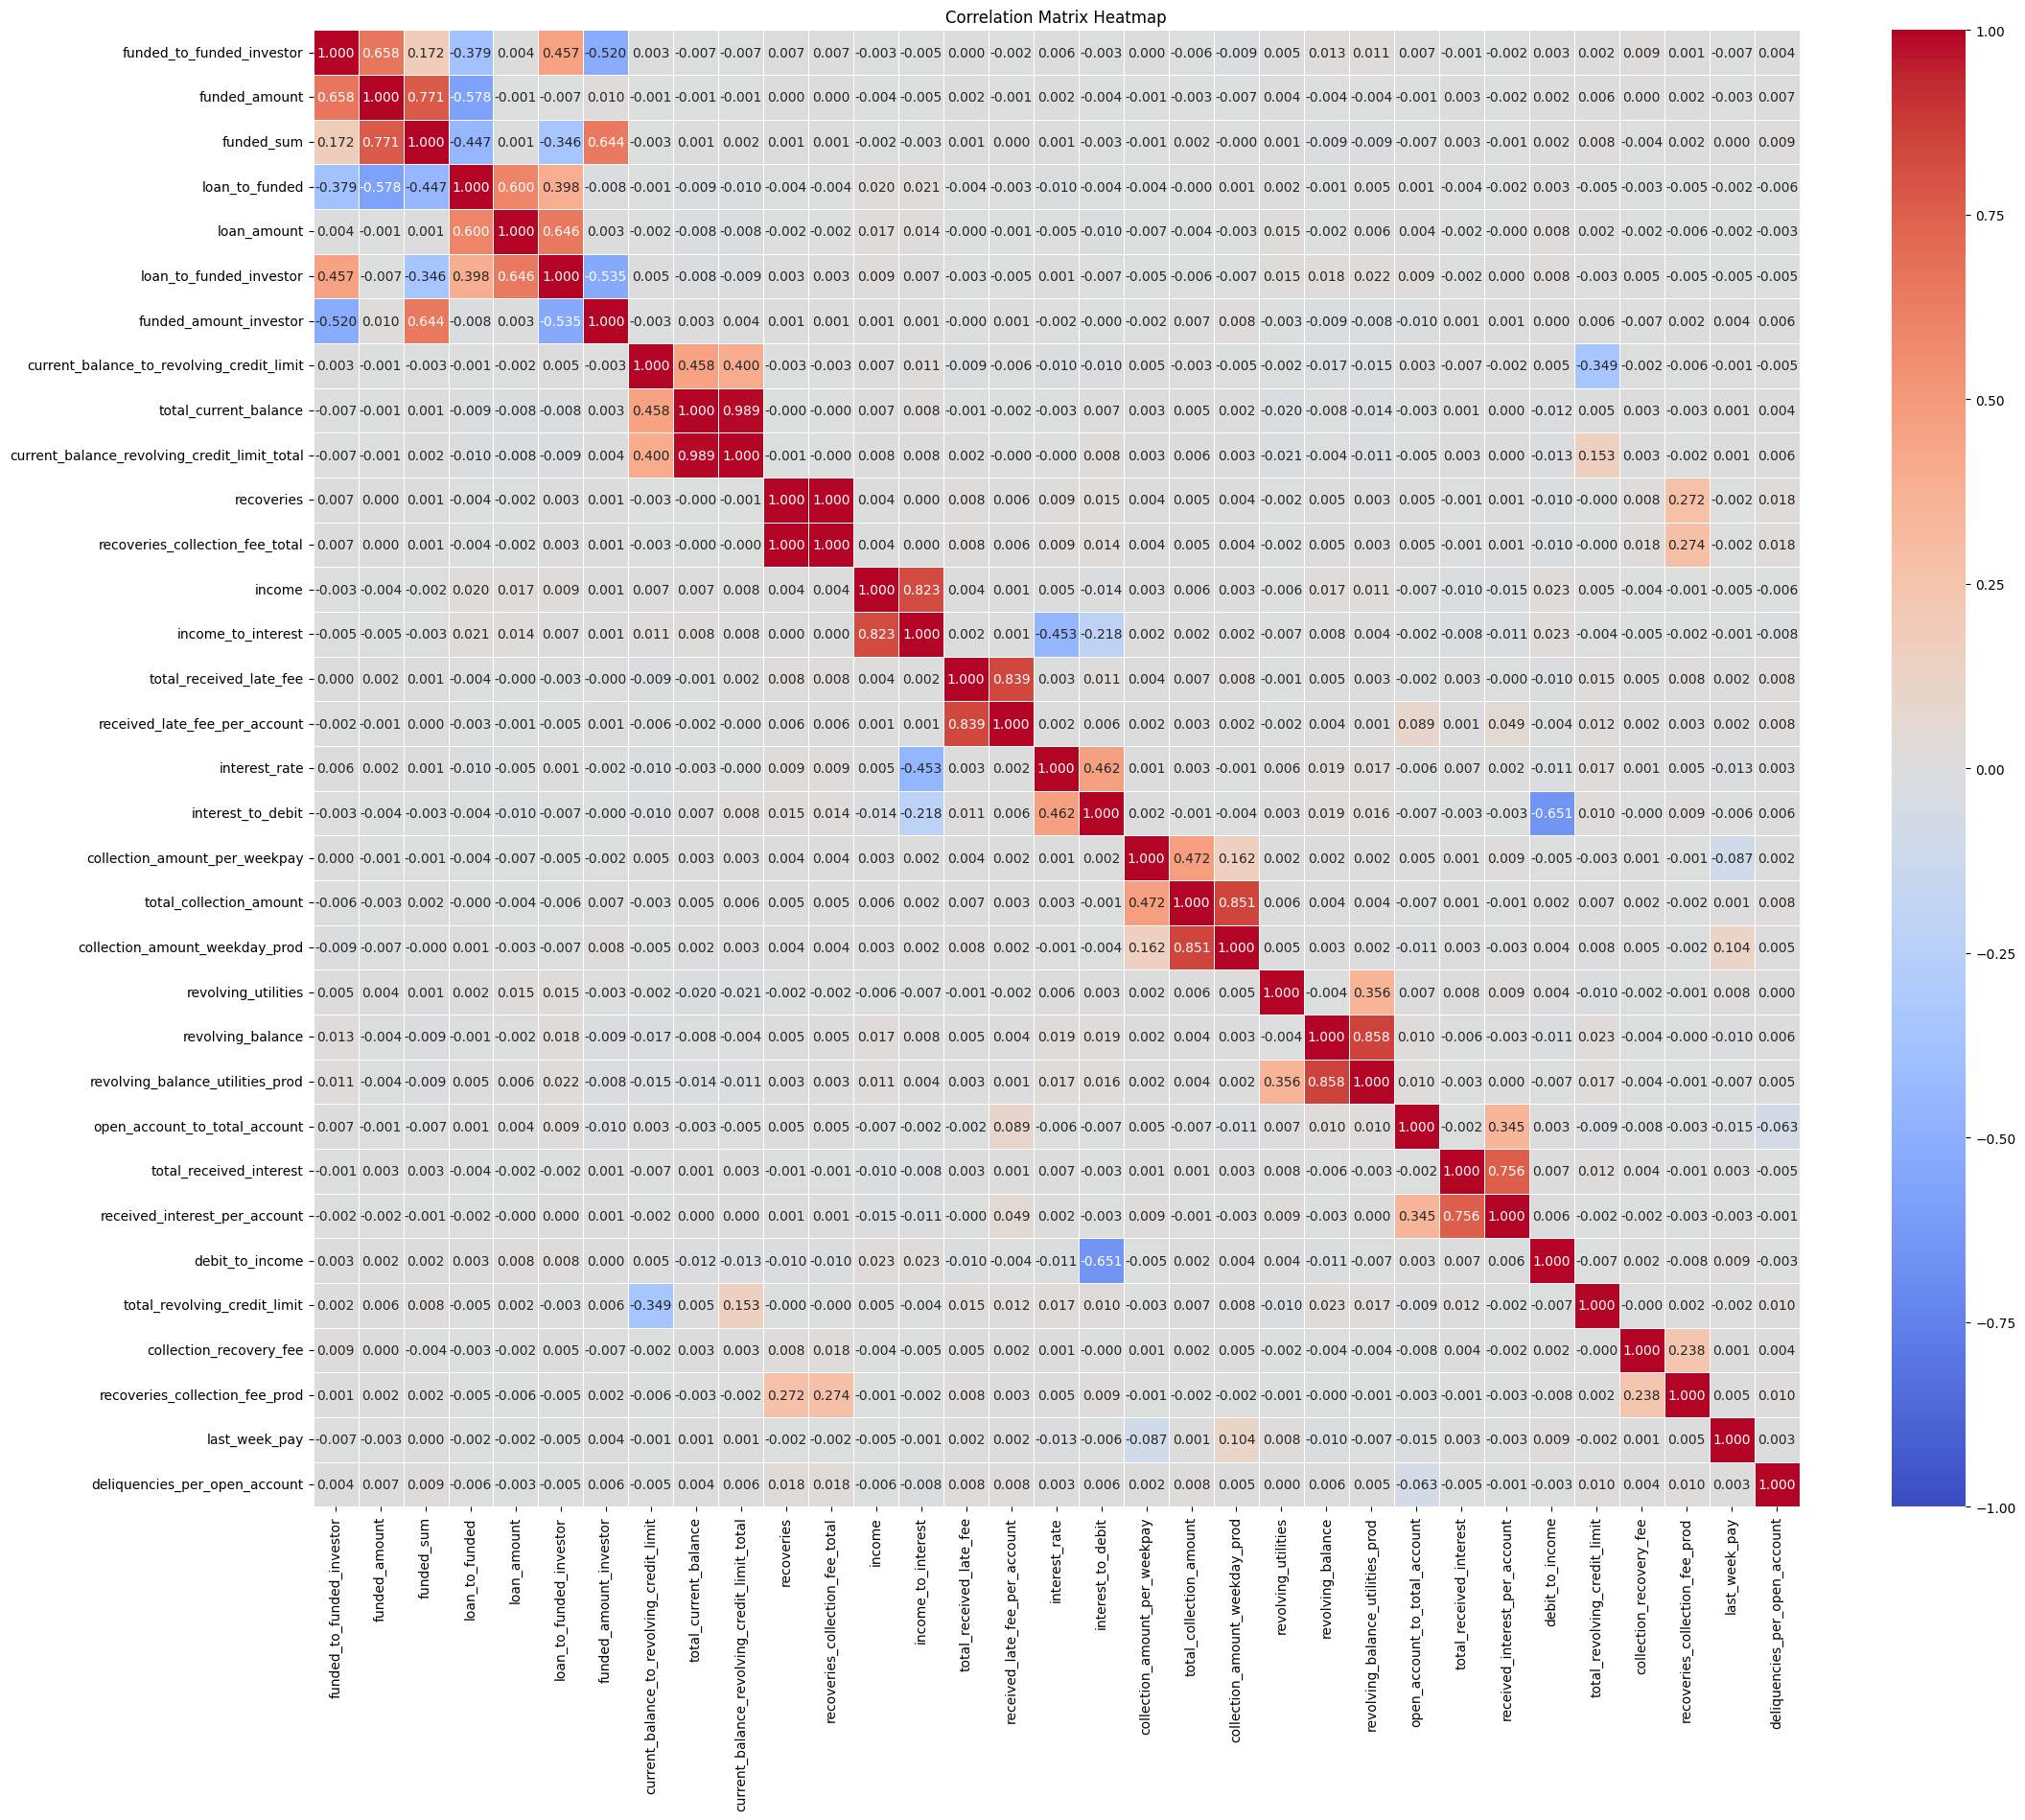

In [49]:
import scipy.cluster.hierarchy as sch

# calculate the correlation among continuous variables
X_corr = X[continuous_vars].corr()

# Perform hierarchical clustering to order the correlation matrix
corr_linkage = sch.linkage(X_corr, method='average')
clustered_idx = sch.leaves_list(corr_linkage)

# Reorder the correlation matrix with the clustered indices
X_corr_clustered = X_corr.iloc[clustered_idx, clustered_idx]

# Plot the heatmap with clustered correlation matrix - now we can see the highly correlated variables clustered together more easily
plt.figure(figsize=(25, 20))
sns.heatmap(X_corr_clustered, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
            linewidths=.5, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()

We can see that other than the extra variables we created being highly correlated with the existing variables used to create them (which makes obvious sense), the majority of our numerical variables are not highly correlated with each other.

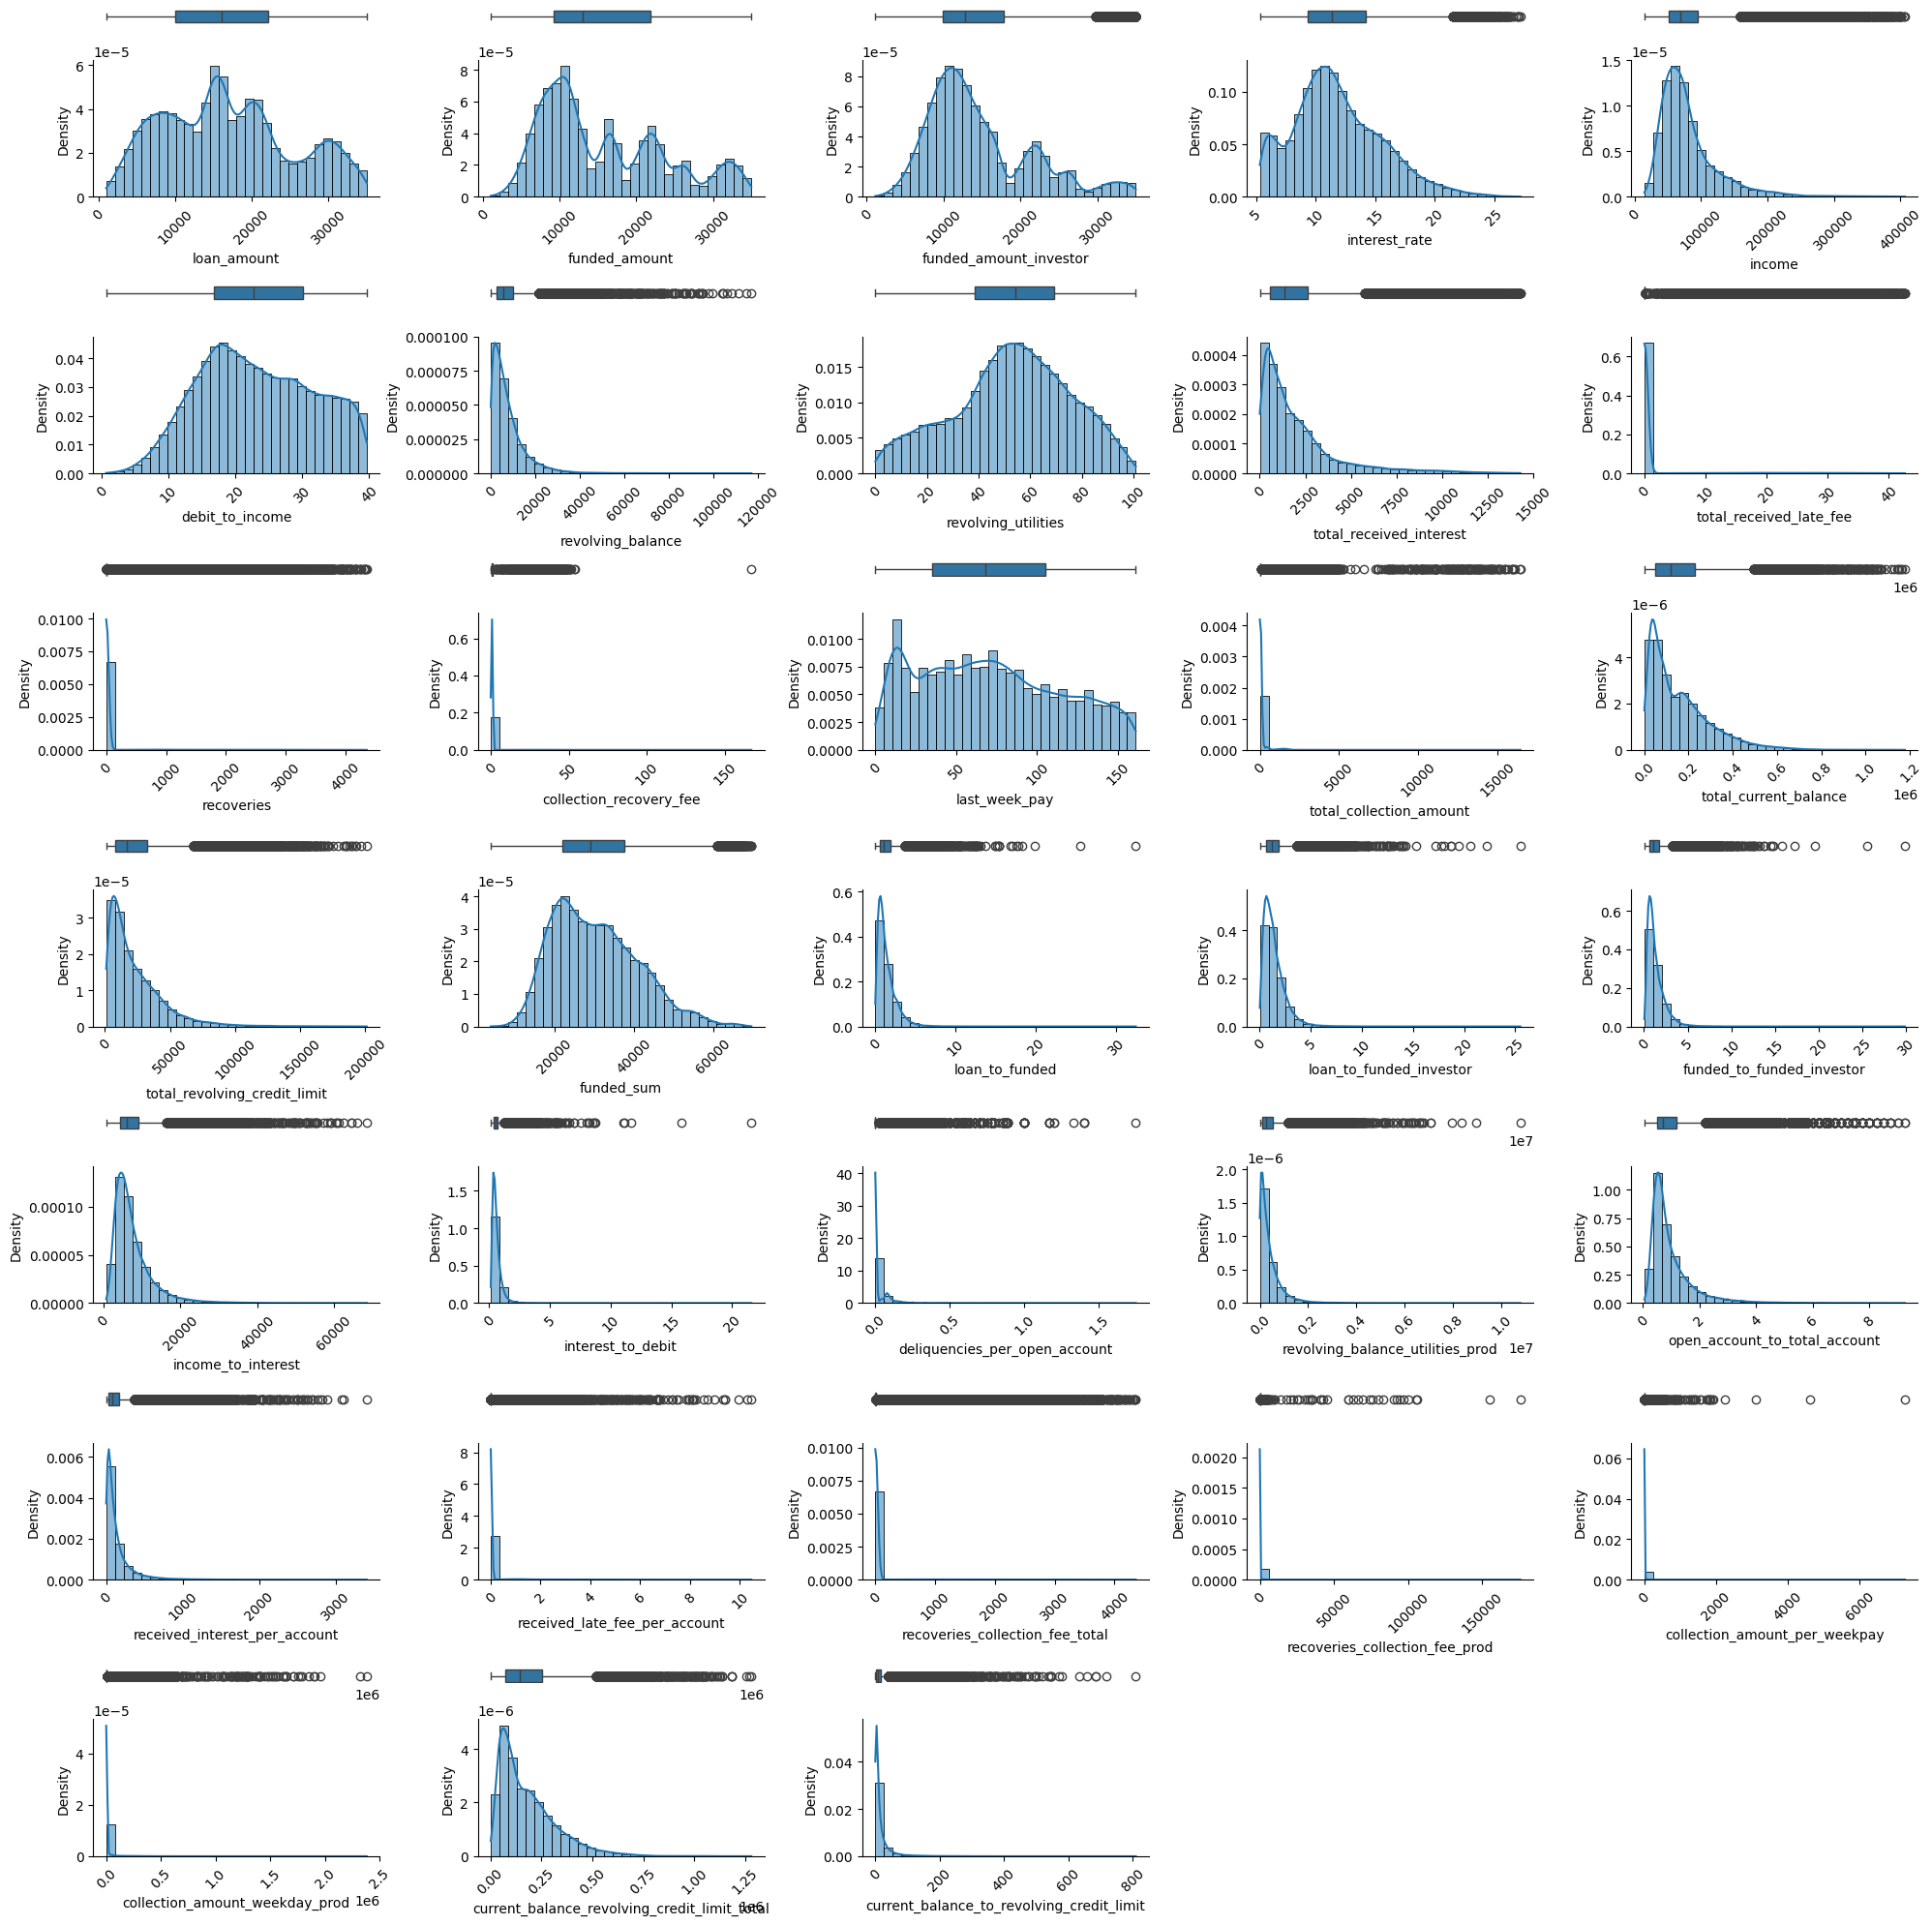

In [50]:
# let's look at the distribution of these variables
fig, ax = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
ax = ax.ravel()
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

for i, var in enumerate(continuous_vars):
    # Turn off the visible axes in the main subplot
    ax[i].set_visible(False)
    # Create the nested subplots within each cell of the main grid
    gs = ax[i].get_subplotspec().subgridspec(2, 1, height_ratios=[.1, .9])

    # Create boxplot in the first nested subplot, share the x-axis with the histogram
    ax_box = fig.add_subplot(gs[0], sharex=ax[i])
    sns.boxplot(x=X[var], ax=ax_box)
    
    # turn off all the ticks on the axes of the box plot
    ax_box.tick_params(left=False, bottom=False)
    # turn off the title on the box plot
    ax_box.set_xlabel('')
    # turn off all spines (edges) around the box plot
    sns.despine(ax=ax_box, left=True, top=True, right=True, bottom=True)

    # Create histogram in the second nested subplot, share x-axis with the boxplot
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    ax_hist.tick_params(axis='x', rotation=45)
    sns.histplot(x=X[var], bins=30, kde=True, stat='density', ax=ax_hist)
    # Remove x-axis ticks from the boxplot (to avoid double labels)
    plt.setp(ax_box.get_xticklabels(), visible=False)

    # Remove extra spines
    sns.despine(ax=ax_hist)

# Increase distance between rows
plt.subplots_adjust(hspace=2.0)  # Adjust this value as needed
plt.tight_layout()
plt.show()

We see many continuous variables are (heavily) right-skewed. So, before applying optimal binning and WoE transformation, we'll need handle outliers and apply some transformation to normalize the distributions.

### 6.2. Outlier handling

We'll use the capping method with the lower threshold = 0.05 and upper threshold = 0.05 to handle outliers.

In [51]:
# create OutlierCapper class
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=None, upper_quantile=None):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.lower_bound_ = X.quantile(self.lower_quantile)
        self.upper_bound_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].clip(lower=self.lower_bound_[var], upper=self.upper_bound_[var])
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [52]:
# create a ColumnTransformer to apply OutlierCapper on our continuous variables

outlier_cap = ColumnTransformer(
    transformers=[
        ('outlier_cap', 
         OutlierCapper(lower_quantile=0.05, upper_quantile=0.95), 
         continuous_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

### 6.3. Skewed distribution handling

The majority of numerical variables' distributions are right-skewed and leptokurtic. Therefore, before discretizing them and applying encoding methods (like Weight of Evidence), we need to transform these variables. There are several methods as below:

1. The **logarithmic transformation** is typically used to handle positively skewed distribution by compressing the values. It converts a variable X using the natural logarithm.
$$X' = log(X+c)$$
Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $c$ is a constant added to X to handle cases where $X <= 0$ (commonly set to 1 to avoid taking log of 0)

2. The **Box-Cox transformation** is more flexible than the log transformation because it inlcudes a parameter $\lambda$ that adjusts the transformation depending on the skewness of the distribution.

$$
X' = 
\begin{cases}
\frac{(X^\lambda - 1)}{\lambda} & \text{if } \lambda \neq 0 \\
log(X) & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $\lambda$ is a parameter that can be optimized to best normalize the data

3. The **Yeo-Johnson transformation** is an extension of the Box-Cox transformation that is no longer constrained to positive values.
$$
X' = 
\begin{cases} 
\frac{((X + 1)^{\lambda} - 1)}{\lambda} & \text{if } \lambda \neq 0 \text{ and } X \geq 0 \\ 
-\frac{((-X + 1)^{2 - \lambda} - 1)}{2 - \lambda} & \text{if } \lambda \neq 2 \text{ and } X < 0 \\ 
\ln(X + 1) & \text{if } \lambda = 0 \text{ and } X \geq 0 \\ 
-\ln(-X + 1) & \text{if } \lambda = 2 \text{ and } X < 0 
\end{cases}
$$

In [53]:
# initialize a PowerTransformer to apply Yeo-Johnson transformation
yeojohnson_transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson_transformer', 
         PowerTransformer(method='yeo-johnson', standardize=False), 
         continuous_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

### 6.4. Event rate encoding with OptBinning

Now we can set up the OptBinningTransformer for these continuous variables.

In [54]:
continuous_enc = OptBinningTransformer(features=continuous_vars,
                                       dtype='numerical',
                                       solver='cp',
                                       monotonic_trend='auto',
                                      transform_metric='event_rate')

Or, instead of WoE transformation, we can apply a standard scaler to these continuous variables

In [55]:
# scaler = StandardScaler().set_output(transform='pandas')

In [56]:
# Create the pipeline for numerical variables, we'll do the fit and transform later
continuous_pipeline = Pipeline(steps=[
    ('outlier_cap', outlier_cap),
    ('yeojohnson_transformer', yeojohnson_transformer),
    ('continuous_enc', continuous_enc),
    # ('scaler', scaler),
])

## 7. Combined pipeline

Now that we have the pipelines for processing discrete and continuous variables, let's combine them into one pipeline and use it to transform the variables.

In [57]:
preprocessing_pipeline = Pipeline(steps=[
    ('discrete_pipeline', discrete_pipeline),
    ('continuous_pipeline', continuous_pipeline),
])

In [58]:
# quick inspection of our data shape before transformation
X.shape, y.shape

((67463, 53), (67463,))

In [59]:
# fit the combined pipeline
preprocessing_pipeline.fit(X, y)

Pipeline(steps=[('discrete_pipeline',
                 Pipeline(steps=[('loan_title_clean',
                                  LoanTitleCleanUp(rare_threshold=0.001)),
                                 ('binary_enc',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('binary_enc',
                                                                   WoEEncoder(),
                                                                   ['initial_list_status',
                                                                    'any_inquires_six_months',
                                                                    'any_delinquency_two_years',
                                                                    'any_collection_12_months_medical',
                                                                    'any_public_record'])],
                                                    verbo...
                                                                  'interest_to_debit',
                                                                  'deliquencies_per_open_account',
                                                                  'revolving_balance_utilities_prod',
                                                                  'open_account_to_total_account',
                                                                  'received_interest_per_account',
                                                                  'received_late_fee_per_account',
                                                                  'recoveries_collection_fee_total',
                                                                  'recoveries_collection_fee_prod',
                                                                  'collection_amount_per_weekpay', ...],
                                                        transform_metric='event_rate',
                                                        user_splits={},
                                                        user_splits_fixed={}))]))])

In [60]:
# transform our data
X = preprocessing_pipeline.transform(X)

In [61]:
X.head()

,loan_amount,funded_amount,funded_amount_investor,interest_rate,income,debit_to_income,revolving_balance,revolving_utilities,total_received_interest,total_received_late_fee,recoveries,collection_recovery_fee,last_week_pay,total_collection_amount,total_current_balance,total_revolving_credit_limit,funded_sum,loan_to_funded,loan_to_funded_investor,funded_to_funded_investor,income_to_interest,interest_to_debit,deliquencies_per_open_account,revolving_balance_utilities_prod,open_account_to_total_account,received_interest_per_account,received_late_fee_per_account,recoveries_collection_fee_total,recoveries_collection_fee_prod,collection_amount_per_weekpay,collection_amount_weekday_prod,current_balance_revolving_credit_limit_total,current_balance_to_revolving_credit_limit,grade,initial_list_status,any_inquires_six_months,any_delinquency_two_years,any_collection_12_months_medical,any_public_record,term,batch_enrolled,sub_grade,home_ownership,verification_status,loan_title,delinquency_two_years,inquires_six_months,open_account,public_record,total_accounts,inquires_per_open_account,records_per_open_account,open_account_total_account_diff
0,0.090571,0.088391,0.091746,0.092404,0.097737,0.094287,0.096647,0.093870,0.093265,0.084769,0.091384,0.094419,0.090826,0.090379,0.096432,0.093415,0.089380,0.094808,0.089060,0.097029,0.097692,0.094361,0.087729,0.095304,0.090849,0.095368,0.106121,0.091455,0.092693,0.095286,0.088166,0.096512,0.095152,0.064479,-2.327124,-2.282679,-2.253939,-2.283007,-2.291567,0.097376,0.094912,-0.007242,0.088663,0.092116,0.089624,-0.006381,-0.000678,0.046720,0.008211,-0.009052,0.001271,0.010046,-0.040846
1,0.106861,0.093534,0.091746,0.092404,0.091056,0.094287,0.078353,0.093870,0.093265,0.094749,0.091384,0.090694,0.095040,0.103812,0.095140,0.094452,0.091113,0.094808,0.098004,0.090786,0.094421,0.094361,0.091700,0.079918,0.090849,0.093508,0.091153,0.091455,0.092693,0.095286,0.098008,0.096512,0.091784,-0.016397,-2.234270,-2.282679,-2.292201,-2.283007,-2.291567,0.097376,0.106494,0.026127,0.095694,0.093383,0.089624,0.008845,-0.000678,-0.013294,0.008211,0.030875,0.001271,0.010046,0.025058
2,0.094178,0.093534,0.094888,0.092404,0.092684,0.093277,0.090620,0.081841,0.093265,0.107369,0.092835,0.076541,0.094465,0.093883,0.091569,0.094452,0.095910,0.086115,0.089060,0.094034,0.089424,0.091418,0.091700,0.093566,0.090849,0.083020,0.106121,0.094405,0.092693,0.095286,0.098008,0.091321,0.093376,-0.069101,-2.327124,-2.282679,-2.292201,-2.283007,-2.291567,0.097376,0.092602,-0.007242,0.088663,0.093383,0.089624,0.008845,-0.000678,0.046720,0.008211,0.030875,0.001271,0.010046,0.025058
3,0.077807,0.087369,0.091362,0.092404,0.097737,0.091871,0.093695,0.093870,0.093265,0.094749,0.100148,0.094419,0.079896,0.094310,0.092248,0.094799,0.091113,0.091718,0.092909,0.094034,0.089424,0.094557,0.106545,0.095304,0.090849,0.092367,0.090026,0.100467,0.093047,0.093837,0.088166,0.091558,0.093376,-0.016397,-2.327124,-2.282679,-2.253939,-2.283007,-2.291567,0.097376,0.092602,0.026127,0.088663,0.093383,0.089624,-0.006381,-0.000678,-0.090891,0.008211,-0.009052,0.001271,0.010046,0.025058
4,0.091176,0.093534,0.091746,0.092404,0.091056,0.094287,0.090620,0.100631,0.093265,0.107369,0.097838,0.099285,0.091228,0.103812,0.091569,0.094452,0.095341,0.091718,0.089060,0.090786,0.094421,0.094361,0.087729,0.092776,0.090849,0.092367,0.106121,0.094405,0.087104,0.093837,0.100431,0.091321,0.081510,-0.016397,-2.327124,-2.289247,-2.253939,-2.283007,-2.176102,0.097376,0.087653,-0.007242,0.088663,0.093383,0.094004,-0.006381,0.005891,0.046720,-0.107256,0.123752,-0.015631,-0.168247,0.148836


In [62]:
# inspect the data shape after transformation
X.shape, y.shape

((67463, 53), (67463,))

In [63]:
# let's also save our preprocessed train dataset
X.to_csv('./data/X.csv', index=False)
y.to_csv('./data/y.csv', index=False)

## 8. Modeling

Now that we have preprocessed our data, let's see which variables are most important for predicting loan default.

In [39]:
# load the processed variables and target
X = pd.read_csv('./data/X.csv')
y = pd.read_csv('./data/y.csv')

In [40]:
X.shape, y.shape

((67463, 53), (67463, 1))

### 8.1. Simple Logistic regression

In [41]:
# first, let's separate our data into a train and test set (just a subset of the data that we are leaving out for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(53970, 53) (53970, 1)
(13493, 53) (13493, 1)


We'll try to remove correlated features based on performance of a logistic regression model.

In [42]:
# logistic regression model
lr = LogisticRegression(C=1.0, max_iter=300, random_state=42)

# correlation selector
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.5,    # (absolute) correlation coefficient threshold
    missing_values="raise",
    selection_method="model_performance",
    estimator=lr,
    scoring="neg_log_loss",
    cv=3,
)

# this may take a while, because we are training
# a random forest per correlation group

sel.fit(X_train, y_train)

SmartCorrelatedSelection(estimator=LogisticRegression(max_iter=300,
                                                      random_state=42),
                         missing_values='raise', scoring='neg_log_loss',
                         selection_method='model_performance', threshold=0.5)

In [43]:
sel.correlated_feature_sets_

[{'any_delinquency_two_years', 'delinquency_two_years'},
 {'any_inquires_six_months',
  'inquires_per_open_account',
  'inquires_six_months'},
 {'any_public_record', 'public_record', 'records_per_open_account'},
 {'collection_amount_weekday_prod', 'total_collection_amount'},
 {'current_balance_revolving_credit_limit_total', 'total_current_balance'},
 {'open_account_to_total_account', 'open_account_total_account_diff'},
 {'received_late_fee_per_account', 'total_received_late_fee'},
 {'revolving_balance', 'revolving_balance_utilities_prod'}]

In [44]:
# the transformer retains 1 best performing feature from each group of correlated feature
# the rest will be dropped
sel.features_to_drop_

['delinquency_two_years',
 'any_inquires_six_months',
 'inquires_per_open_account',
 'public_record',
 'records_per_open_account',
 'total_collection_amount',
 'current_balance_revolving_credit_limit_total',
 'open_account_to_total_account',
 'total_received_late_fee',
 'revolving_balance']

In [45]:
# drop correlated features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((53970, 43), (13493, 43))

In [46]:
# Let's fit a logistic regression model to the selected features
lr = LogisticRegression(max_iter=300, random_state=42, penalty='l1', solver='saga')
lr.fit(X_train, y_train)

# ROC-AUC on train set
print('Train set')
print('Log loss: {}'.format(log_loss(y_train, lr.predict_proba(X_train)[:,1])))

print()
# ROC-AUC on test set
print('Test set')
print('Log loss: {}'.format(log_loss(y_test, lr.predict_proba(X_test)[:,1])))

Train set
Log loss: 0.30751807153777183

Test set
Log loss: 0.30137125886075744


We achieve 90% accuracy for both the train and test set, and about 0.3 for the logloss. Let's see how the confusion matrix looks like.

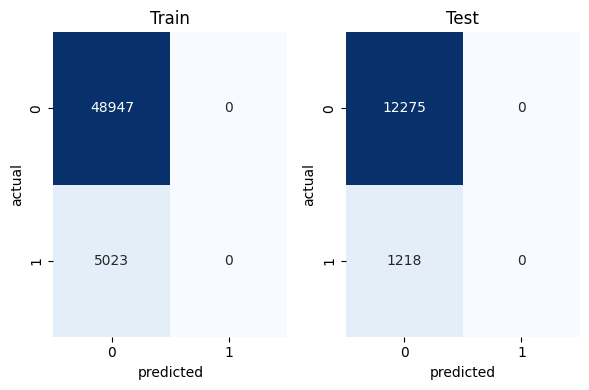

In [47]:
# plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
cm_train = confusion_matrix(y_train, lr.predict(X_train))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title('Train')
ax[0].set_xlabel('predicted')
ax[0].set_ylabel('actual')

cm_test = confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False)
ax[1].set_title('Test')
ax[1].set_xlabel('predicted')
ax[1].set_ylabel('actual')

plt.tight_layout()
plt.show()

In this circumstances, as all the people would have less than 50% of probability to be a defaulter, any model would predict only 0s. The `predict()` method, however, assumes a 50% threshold by default, which is why we end up with only 0s for our prediction here.

Metrics like accuracy score, precision, f1 score, recall and AUC wouldn't be effective for this problem. Because of this, the organizers chose a metric based on the probability of a person to be a defaulter or not. The metric chosen was the Log Loss metric.

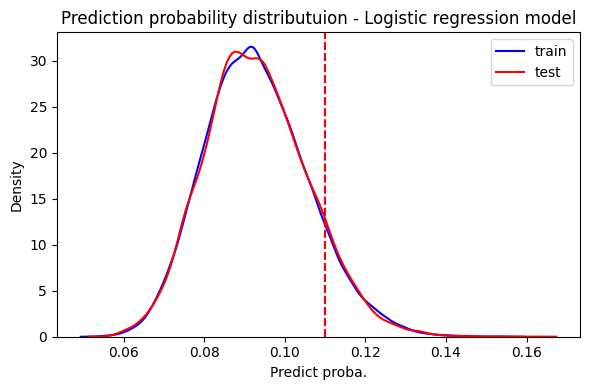

0.11008359728435775


In [48]:
# plot the distribution of preidiction prob on the train and test set
train_pred_proba = lr.predict_proba(X_train)[:, 1]
test_pred_proba = lr.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(train_pred_proba, color='b', fill=False, alpha=1, label='train', ax=ax)
sns.kdeplot(test_pred_proba, color='r', fill=False, alpha=1, label='test', ax=ax)

# Calculate the 90th quantile of the prediction probabilities
train_quantile_90 = np.quantile(train_pred_proba, 0.90)
test_quantile_90 = np.quantile(test_pred_proba, 0.90)

# Add vertical line at the 10th quantile
ax.axvline(train_quantile_90, color='b', linestyle='--')
ax.axvline(test_quantile_90, color='r', linestyle='--')

ax.set_xlabel('Predict proba.')
ax.set_ylabel('Density')
ax.set_title('Prediction probability distributuion - Logistic regression model')
ax.legend()
plt.tight_layout()
plt.show()

print(train_quantile_90)

### 8.2. Ensemble models with hyperparameter tuning

In [26]:
# first, let's separate our data into a train and test set (just a subset of the data that we are leaving out for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(53970, 53) (53970, 1)
(13493, 53) (13493, 1)


For the ensemble models, multicollinearity is not necessarily the problem. So we can skip filtering features based on correlation and focus more on hyperparameter optimization.

Let's play with some hyperparameter tuning using our feature subset. We'll set our metric to be optimized to be Logloss. We will use `optuna` to define an objective function to be optimized.

#### 8.2.1. Random Forest Classifier

In [71]:
def objective(trial):
    # set up the parameters for the LGBM classifier
    param = {
        'criterion': 'log_loss',
        'n_estimators': trial.suggest_int('rf_n_estimators', 500, 1000),
        'min_samples_split': trial.suggest_float('rf_min_samples_split', 0.1, 0.9),
        'min_samples_leaf': trial.suggest_float('rf_min_samples_leaf', 0.1, 0.9),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
        'random_state': 42
    }
    # create a model with the parameters
    model = RandomForestClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [72]:
# create a study
study = optuna.create_study(
    study_name='rf_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 30
try:
    study.optimize(objective, n_trials=30)
except:
    raise

[I 2024-10-26 19:07:26,478] A new study created in memory with name: rf_study
[I 2024-10-26 19:07:37,535] Trial 0 finished with value: 0.30958427110751674 and parameters: {'rf_n_estimators': 516, 'rf_min_samples_split': 0.7245316058781258, 'rf_min_samples_leaf': 0.8062488758667763, 'rf_max_depth': 3}. Best is trial 0 with value: 0.30958427110751674.
[I 2024-10-26 19:07:48,006] Trial 1 finished with value: 0.30958429049821673 and parameters: {'rf_n_estimators': 622, 'rf_min_samples_split': 0.4914528215904558, 'rf_min_samples_leaf': 0.3992668912227212, 'rf_max_depth': 3}. Best is trial 0 with value: 0.30958427110751674.
[I 2024-10-26 19:07:57,283] Trial 2 finished with value: 0.3095842910649539 and parameters: {'rf_n_estimators': 624, 'rf_min_samples_split': 0.6296042743548151, 'rf_min_samples_leaf': 0.8647988763623968, 'rf_max_depth': 3}. Best is trial 0 with value: 0.30958427110751674.
[I 2024-10-26 19:08:10,736] Trial 3 finished with value: 0.30958426707216746 and parameters: {'rf_n_e

In [73]:
# examine the best parameters found during the trials
study.best_params

{'rf_n_estimators': 532,
 'rf_min_samples_split': 0.19756490714049538,
 'rf_min_samples_leaf': 0.1002058414545336,
 'rf_max_depth': 10}

In [74]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.3090197956524202

In [75]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_rf_max_depth,params_rf_min_samples_leaf,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.309584,2024-10-26 19:07:26.496938,2024-10-26 19:07:37.527056,0 days 00:00:11.030118,3,0.806249,0.724532,516,COMPLETE
1,1,0.309584,2024-10-26 19:07:37.538832,2024-10-26 19:07:48.006349,0 days 00:00:10.467517,3,0.399267,0.491453,622,COMPLETE
2,2,0.309584,2024-10-26 19:07:48.009795,2024-10-26 19:07:57.283723,0 days 00:00:09.273928,3,0.864799,0.629604,624,COMPLETE
3,3,0.309584,2024-10-26 19:07:57.284717,2024-10-26 19:08:10.736114,0 days 00:00:13.451397,7,0.137793,0.664390,862,COMPLETE
4,4,0.309584,2024-10-26 19:08:10.737226,2024-10-26 19:08:24.035000,0 days 00:00:13.297774,3,0.895709,0.319544,867,COMPLETE
5,5,0.309584,2024-10-26 19:08:24.036336,2024-10-26 19:08:36.873985,0 days 00:00:12.837649,4,0.523782,0.676753,801,COMPLETE
6,6,0.309584,2024-10-26 19:08:36.877687,2024-10-26 19:08:45.504660,0 days 00:00:08.626973,7,0.825710,0.129861,557,COMPLETE
7,7,0.309584,2024-10-26 19:08:45.507597,2024-10-26 19:08:59.627095,0 days 00:00:14.119498,9,0.484514,0.270858,921,COMPLETE
8,8,0.309584,2024-10-26 19:08:59.630462,2024-10-26 19:09:14.638199,0 days 00:00:15.007737,8,0.355744,0.427522,974,COMPLETE
9,9,0.309584,2024-10-26 19:09:14.639252,2024-10-26 19:09:27.047792,0 days 00:00:12.408540,4,0.512147,0.302269,815,COMPLETE


In [79]:
# we can check out which trial yield the best result
study.trials_dataframe()['value'].idxmin()

25

In [76]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/rf_trials.csv', index=False)

Text(0, 0.5, 'Log loss')

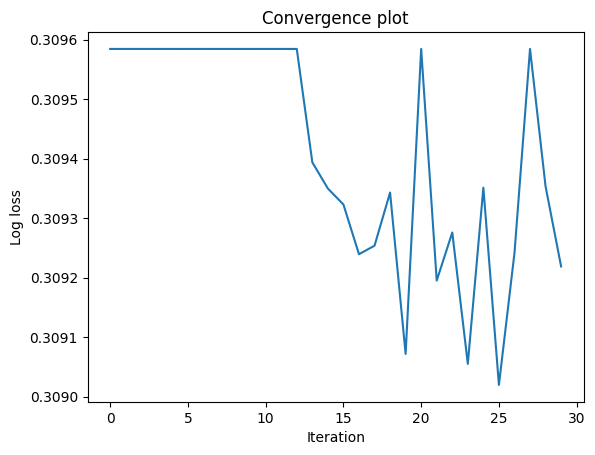

In [77]:
# let's see how the logloss looks over the trials
study.trials_dataframe()['value'].plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
# plt.ylim(0.309, 0.31)
plt.ylabel('Log loss')

With a `RandomForestClassifier`, we achieved lowest log-loss at around 0.3092. Let's see which hyperparameters were most influential on the loss function.

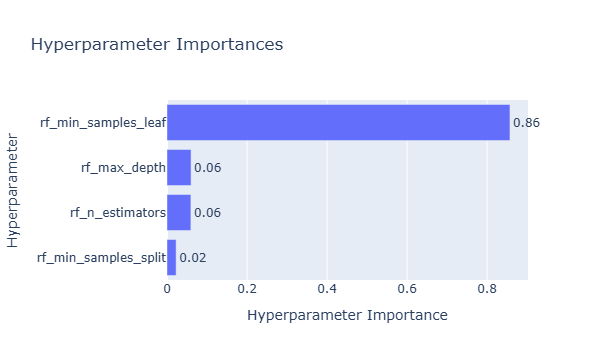

In [78]:
# plot hyperparameter importances
fig = optuna.visualization.plot_param_importances(study)
fig.show()

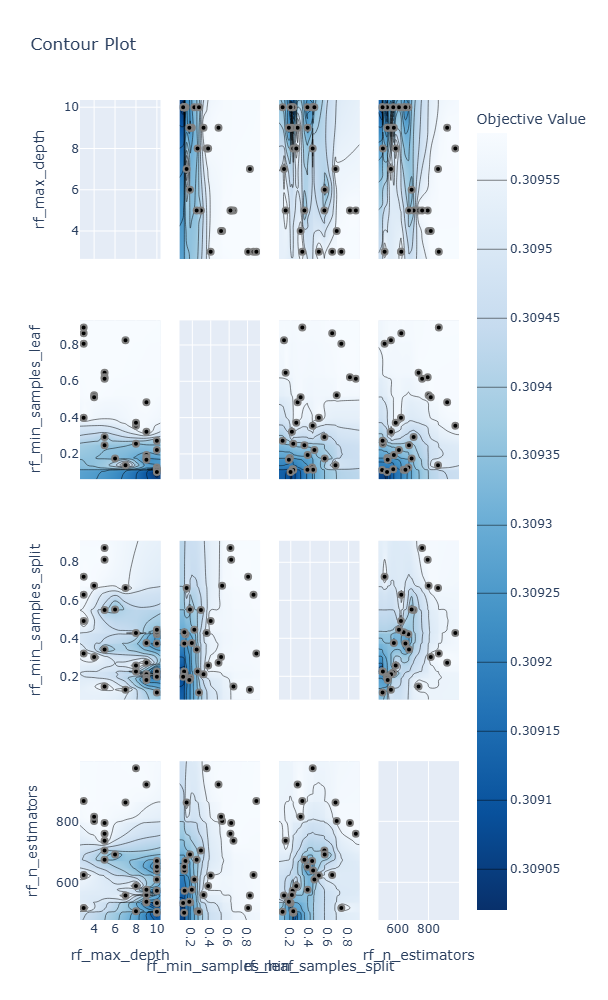

In [84]:
# see how the hyperparameters affect the loss function
fig = optuna.visualization.plot_contour(study)

fig.update_layout(
    width=1000,                           # Set the desired width of the figure
    height=1000,                         # Set the desired height of the figure
)

pio.show(fig)

#### 8.2.2. Light GBM Classifier

In [85]:
def objective(trial):
    # set up the parameters for the LGBM classifier
    param = {
        'metric': 'logloss',
        'reg_lambda': trial.suggest_loguniform('lgbm_reg_lambda', 1, 10.0),
        'reg_alpha': trial.suggest_loguniform('lgbm_reg_alpha', 1e-2, 1.0),
        'colsample_bytree': trial.suggest_categorical('lgbm_colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('lgbm_subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('lgbm_learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': 1000,
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 16, 128),
        'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 100, 300),
        'max_depth': trial.suggest_int('lgbm_max_depth', 7, 20),
        'min_child_weight': trial.suggest_int('lgbm_min_child_weight', 150, 300),
        'random_state': 42,
        'verbose': -1
    }
    # create a model with the parameters
    model = LGBMClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [86]:
# create a study
study = optuna.create_study(
    study_name='lgbm_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 30
try:
    study.optimize(objective, n_trials=30)
except:
    raise

[I 2024-10-26 19:24:10,502] A new study created in memory with name: lgbm_study
[I 2024-10-26 19:24:20,977] Trial 0 finished with value: 0.3080830495836554 and parameters: {'lgbm_reg_lambda': 1.3355294999547305, 'lgbm_reg_alpha': 0.5679842006631762, 'lgbm_colsample_bytree': 0.9, 'lgbm_subsample': 0.6, 'lgbm_learning_rate': 0.008, 'lgbm_num_leaves': 105, 'lgbm_min_child_samples': 283, 'lgbm_max_depth': 14, 'lgbm_min_child_weight': 271}. Best is trial 0 with value: 0.3080830495836554.
[I 2024-10-26 19:24:29,346] Trial 1 finished with value: 0.30791624367759096 and parameters: {'lgbm_reg_lambda': 2.318057375317405, 'lgbm_reg_alpha': 0.14490686953535617, 'lgbm_colsample_bytree': 0.6, 'lgbm_subsample': 0.7, 'lgbm_learning_rate': 0.008, 'lgbm_num_leaves': 73, 'lgbm_min_child_samples': 202, 'lgbm_max_depth': 7, 'lgbm_min_child_weight': 289}. Best is trial 1 with value: 0.30791624367759096.
[I 2024-10-26 19:24:38,596] Trial 2 finished with value: 0.3084229860748483 and parameters: {'lgbm_reg_l

In [87]:
# examine the best parameters found during the trials
study.best_params

{'lgbm_reg_lambda': 4.569696091689602,
 'lgbm_reg_alpha': 0.06250091484876927,
 'lgbm_colsample_bytree': 0.3,
 'lgbm_subsample': 0.4,
 'lgbm_learning_rate': 0.008,
 'lgbm_num_leaves': 16,
 'lgbm_min_child_samples': 169,
 'lgbm_max_depth': 18,
 'lgbm_min_child_weight': 171}

In [92]:
# we can check out which trial yield the best result
study.trials_dataframe()['value'].idxmin()

19

In [88]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.30766770795795156

In [89]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_lgbm_colsample_bytree,params_lgbm_learning_rate,params_lgbm_max_depth,params_lgbm_min_child_samples,params_lgbm_min_child_weight,params_lgbm_num_leaves,params_lgbm_reg_alpha,params_lgbm_reg_lambda,params_lgbm_subsample,state
0,0,0.308083,2024-10-26 19:24:10.517967,2024-10-26 19:24:20.974059,0 days 00:00:10.456092,0.9,0.008,14,283,271,105,0.567984,1.335529,0.6,COMPLETE
1,1,0.307916,2024-10-26 19:24:20.978988,2024-10-26 19:24:29.346550,0 days 00:00:08.367562,0.6,0.008,7,202,289,73,0.144907,2.318057,0.7,COMPLETE
2,2,0.308423,2024-10-26 19:24:29.347848,2024-10-26 19:24:38.595729,0 days 00:00:09.247881,0.8,0.012,15,247,228,114,0.011523,1.628597,0.7,COMPLETE
3,3,0.308036,2024-10-26 19:24:38.596956,2024-10-26 19:24:47.891335,0 days 00:00:09.294379,0.7,0.009,13,214,236,84,0.049292,6.418585,0.5,COMPLETE
4,4,0.308884,2024-10-26 19:24:47.893061,2024-10-26 19:24:57.373666,0 days 00:00:09.480605,0.8,0.020,14,132,273,81,0.675421,5.488718,0.8,COMPLETE
5,5,0.308313,2024-10-26 19:24:57.374943,2024-10-26 19:25:09.149428,0 days 00:00:11.774485,0.7,0.012,9,195,162,62,0.066690,1.814808,0.6,COMPLETE
6,6,0.308228,2024-10-26 19:25:09.150885,2024-10-26 19:25:19.873939,0 days 00:00:10.723054,0.8,0.009,12,265,154,60,0.119407,3.549143,0.6,COMPLETE
7,7,0.308661,2024-10-26 19:25:19.875160,2024-10-26 19:25:27.670563,0 days 00:00:07.795403,0.4,0.020,12,289,216,115,0.043303,2.875799,1.0,COMPLETE
8,8,0.307908,2024-10-26 19:25:27.672059,2024-10-26 19:25:35.480286,0 days 00:00:07.808227,0.5,0.010,9,246,282,74,0.121739,1.946136,0.6,COMPLETE
9,9,0.308904,2024-10-26 19:25:35.483386,2024-10-26 19:25:44.479199,0 days 00:00:08.995813,0.5,0.020,16,207,209,64,0.015320,3.662257,0.4,COMPLETE


In [90]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/lgbm_trials.csv', index=False)

Text(0, 0.5, 'Log loss')

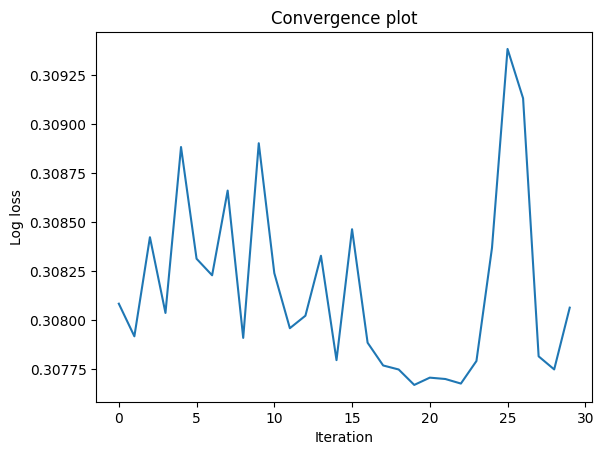

In [91]:
# let's see how the logloss looks over the trials
study.trials_dataframe()['value'].plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
# plt.ylim(0.3, 0.4)
plt.ylabel('Log loss')

With the `LightGBMClassifier`, we achieved a lower log-loss, at 0.3078.

#### 8.2.2. XGBoost Classifier

Let's try a different classifier - the XGBoost Classifier.

In [93]:
def objective(trial):
    # set up the parameters for the XGB classifier
    param = {
        'learning_rate': trial.suggest_categorical('xgb_learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_int('xgb_n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('xgb_min_child_weight', 3.0, 7.0),
        'gamma': trial.suggest_float('xgb_gamma', 0.3, 0.5),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_loguniform('xgb_reg_alpha', 5.0, 15.0),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 3, 10),
        'scale_pos_weight': trial.suggest_loguniform('xgb_scale_pos_weight', 0.8, 1.2),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [94]:
# create a study
study = optuna.create_study(
    study_name='xgb_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 30
try:
    study.optimize(objective, n_trials=30)
except:
    raise

[I 2024-10-26 19:31:08,701] A new study created in memory with name: xgb_study
[I 2024-10-26 19:31:20,238] Trial 0 finished with value: 0.30933077256220143 and parameters: {'xgb_learning_rate': 0.018, 'xgb_n_estimators': 946, 'xgb_max_depth': 5, 'xgb_min_child_weight': 5.847594901813433, 'xgb_gamma': 0.4114110426476259, 'xgb_subsample': 0.8966259453075247, 'xgb_colsample_bytree': 0.5882655796193967, 'xgb_reg_alpha': 7.906368217965706, 'xgb_reg_lambda': 9.121442558926157, 'xgb_scale_pos_weight': 0.8621223354571086}. Best is trial 0 with value: 0.30933077256220143.
[I 2024-10-26 19:31:28,001] Trial 1 finished with value: 0.3089815839983342 and parameters: {'xgb_learning_rate': 0.018, 'xgb_n_estimators': 678, 'xgb_max_depth': 6, 'xgb_min_child_weight': 3.4965878818628773, 'xgb_gamma': 0.47580540627635837, 'xgb_subsample': 0.9833641107910138, 'xgb_colsample_bytree': 0.6879408848199295, 'xgb_reg_alpha': 6.477391533252296, 'xgb_reg_lambda': 8.79333098288541, 'xgb_scale_pos_weight': 1.0863738

In [95]:
# examine the best parameters found during the trials
study.best_params

{'xgb_learning_rate': 0.008,
 'xgb_n_estimators': 783,
 'xgb_max_depth': 6,
 'xgb_min_child_weight': 3.5618453854222576,
 'xgb_gamma': 0.4670251239800064,
 'xgb_subsample': 0.5864478645164526,
 'xgb_colsample_bytree': 0.6962169001992004,
 'xgb_reg_alpha': 7.531624450076858,
 'xgb_reg_lambda': 5.121346582216894,
 'xgb_scale_pos_weight': 1.0067595711828483}

In [96]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.30773354922462975

In [97]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_reg_alpha,params_xgb_reg_lambda,params_xgb_scale_pos_weight,params_xgb_subsample,state
0,0,0.309331,2024-10-26 19:31:08.722812,2024-10-26 19:31:20.236309,0 days 00:00:11.513497,0.588266,0.411411,0.018,5,5.847595,946,7.906368,9.121443,0.862122,0.896626,COMPLETE
1,1,0.308982,2024-10-26 19:31:20.239540,2024-10-26 19:31:28.001391,0 days 00:00:07.761851,0.687941,0.475805,0.018,6,3.496588,678,6.477392,8.793331,1.086374,0.983364,COMPLETE
2,2,0.309662,2024-10-26 19:31:28.002711,2024-10-26 19:31:33.258089,0 days 00:00:05.255378,0.569621,0.427740,0.018,5,3.418862,932,10.786911,7.240001,0.815667,0.953224,COMPLETE
3,3,0.309174,2024-10-26 19:31:33.259336,2024-10-26 19:31:43.244892,0 days 00:00:09.985556,0.823948,0.491114,0.008,7,6.241276,1000,11.883443,3.833487,1.160501,0.883034,COMPLETE
4,4,0.309926,2024-10-26 19:31:43.246706,2024-10-26 19:32:08.618922,0 days 00:00:25.372216,0.879593,0.408801,0.010,9,6.426079,778,5.829935,6.086328,1.155351,0.933498,COMPLETE
5,5,0.309110,2024-10-26 19:32:08.620781,2024-10-26 19:32:14.456278,0 days 00:00:05.835497,0.713430,0.417331,0.009,4,4.951419,698,5.264856,3.161318,1.197495,0.625247,COMPLETE
6,6,0.308170,2024-10-26 19:32:14.458837,2024-10-26 19:32:19.417723,0 days 00:00:04.958886,0.576124,0.325610,0.010,7,5.004016,546,11.996278,4.717627,0.927446,0.978341,COMPLETE
7,7,0.307840,2024-10-26 19:32:19.418963,2024-10-26 19:32:23.330237,0 days 00:00:03.911274,0.692204,0.450397,0.008,7,4.107163,597,14.977044,3.381694,0.990032,0.646816,COMPLETE
8,8,0.309924,2024-10-26 19:32:23.331779,2024-10-26 19:32:26.235205,0 days 00:00:02.903426,0.865712,0.407285,0.010,3,5.581178,611,11.874908,6.379649,0.812638,0.979015,COMPLETE
9,9,0.309871,2024-10-26 19:32:26.236500,2024-10-26 19:32:40.936107,0 days 00:00:14.699607,0.652636,0.412882,0.016,9,4.671383,630,7.755064,6.279956,0.841686,0.832748,COMPLETE


In [98]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/xgb_trials.csv', index=False)

Text(0, 0.5, 'Log loss')

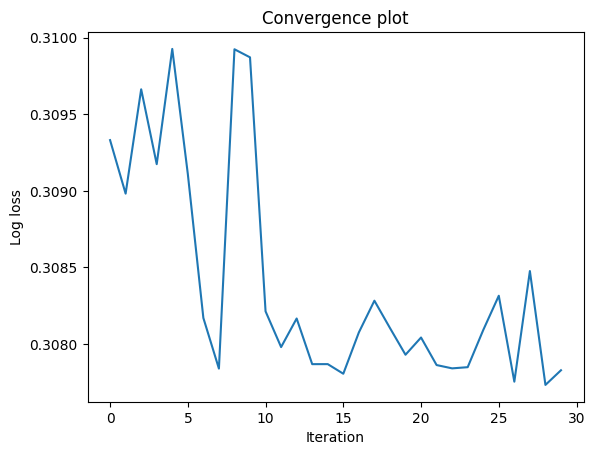

In [99]:
# let's see how the logloss looks over the trials
study.trials_dataframe()['value'].plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
# plt.ylim(0.3, 0.4)
plt.ylabel('Log loss')

With `XGBClassifier`, we achieve roughly the same log-loss as the Light GBM classifier.

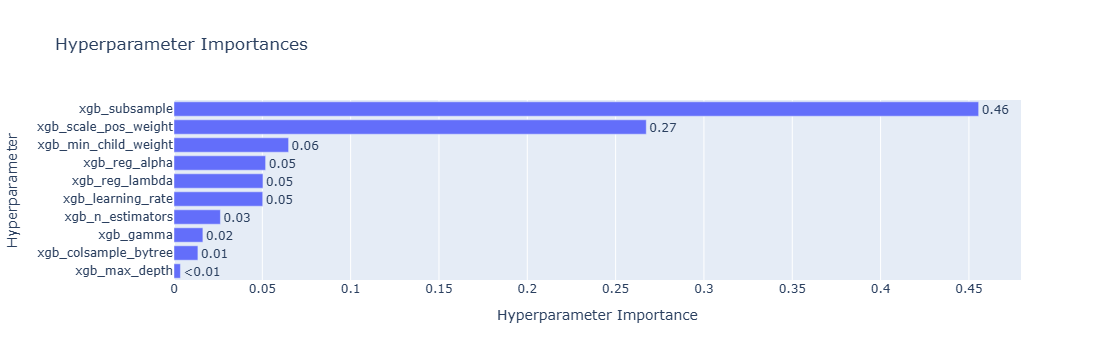

In [103]:
# plot hyperparameter importances
fig = optuna.visualization.plot_param_importances(study)
fig.show()

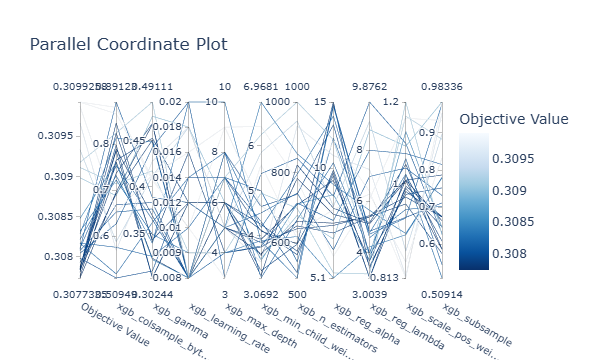

In [104]:
# a more detailed view of how each parameter affects the objective score
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

Seems like the 2 most important hyperparameters for XGBClassifier is `scale_pos_weight` and `subsample`

#### 8.2.3. CatBoost Classifier

Let's try the CatBoost classifier this time

In [109]:
def objective(trial):
    # set up the parameters for the CatBoost classifier
    param = {
        'early_stopping_rounds': 100,
        'learning_rate': trial.suggest_loguniform('cb_learning_rate', 9e-3, 9e-2),
        'n_estimators': trial.suggest_int('cb_n_estimators', 700, 1000),
        'depth': trial.suggest_int('cb_depth', 6, 10),
        'l2_leaf_reg': trial.suggest_loguniform('cb_l2_leaf_reg', 5.0, 10.0),
        'random_strength': trial.suggest_float('cb_random_strength', 3, 10),
        'bagging_temperature': trial.suggest_uniform('cb_bagging_temperature', 0, 0.5),
        'random_state': 42,
        'logging_level': 'Silent',
        'eval_metric': 'Logloss',
        "colsample_bylevel": trial.suggest_float("cb_colsample_bylevel", 0.3, 0.5),
        "border_count": 254,
    }
    model = CatBoostClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [110]:
# create a study
study = optuna.create_study(
    study_name='catboost_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 30
try:
    study.optimize(objective, n_trials=30)
except:
    raise

[I 2024-10-26 19:46:08,023] A new study created in memory with name: catboost_study
[I 2024-10-26 19:46:43,235] Trial 0 finished with value: 0.33013177178318853 and parameters: {'cb_learning_rate': 0.08259784035090383, 'cb_n_estimators': 821, 'cb_depth': 8, 'cb_l2_leaf_reg': 6.10900862056091, 'cb_random_strength': 6.446354864516535, 'cb_bagging_temperature': 0.46491243487693856, 'cb_colsample_bylevel': 0.3746045389418504}. Best is trial 0 with value: 0.33013177178318853.
[I 2024-10-26 19:47:39,540] Trial 1 finished with value: 0.3266254561615585 and parameters: {'cb_learning_rate': 0.05424583175096426, 'cb_n_estimators': 771, 'cb_depth': 10, 'cb_l2_leaf_reg': 9.07042597242643, 'cb_random_strength': 5.182711138975499, 'cb_bagging_temperature': 0.0806563742968075, 'cb_colsample_bylevel': 0.42737555120141746}. Best is trial 1 with value: 0.3266254561615585.
[I 2024-10-26 19:48:10,557] Trial 2 finished with value: 0.3076682635578222 and parameters: {'cb_learning_rate': 0.020403203381737567

In [111]:
# examine the best parameters found during the trials
study.best_params

{'cb_learning_rate': 0.011936869897820133,
 'cb_n_estimators': 938,
 'cb_depth': 7,
 'cb_l2_leaf_reg': 5.515311166458147,
 'cb_random_strength': 8.80636939848394,
 'cb_bagging_temperature': 0.1427804858401882,
 'cb_colsample_bylevel': 0.3017393168609862}

In [112]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.3070884427222682

In [113]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_cb_bagging_temperature,params_cb_colsample_bylevel,params_cb_depth,params_cb_l2_leaf_reg,params_cb_learning_rate,params_cb_n_estimators,params_cb_random_strength,state
0,0,0.330132,2024-10-26 19:46:08.028228,2024-10-26 19:46:43.235244,0 days 00:00:35.207016,0.464912,0.374605,8,6.109009,0.082598,821,6.446355,COMPLETE
1,1,0.326625,2024-10-26 19:46:43.236402,2024-10-26 19:47:39.540570,0 days 00:00:56.304168,0.080656,0.427376,10,9.070426,0.054246,771,5.182711,COMPLETE
2,2,0.307668,2024-10-26 19:47:39.541604,2024-10-26 19:48:10.556556,0 days 00:00:31.014952,0.049466,0.490035,7,9.267188,0.020403,898,7.103952,COMPLETE
3,3,0.308319,2024-10-26 19:48:10.559847,2024-10-26 19:48:59.852906,0 days 00:00:49.293059,0.155299,0.390416,9,5.294255,0.015664,995,8.508007,COMPLETE
4,4,0.307306,2024-10-26 19:48:59.854340,2024-10-26 19:49:27.739573,0 days 00:00:27.885233,0.071334,0.405482,6,6.481437,0.015193,996,5.060798,COMPLETE
5,5,0.307639,2024-10-26 19:49:27.740853,2024-10-26 19:50:25.311826,0 days 00:00:57.570973,0.329277,0.409696,10,6.994518,0.014924,735,4.480362,COMPLETE
6,6,0.307813,2024-10-26 19:50:25.313799,2024-10-26 19:51:07.459903,0 days 00:00:42.146104,0.042177,0.319787,9,9.417042,0.018609,718,7.497027,COMPLETE
7,7,0.308225,2024-10-26 19:51:07.461034,2024-10-26 19:51:43.711441,0 days 00:00:36.250407,0.376641,0.371476,9,7.239102,0.021173,730,6.133142,COMPLETE
8,8,0.307168,2024-10-26 19:51:43.712322,2024-10-26 19:52:04.887065,0 days 00:00:21.174743,0.292198,0.381550,7,5.999374,0.015213,730,9.936956,COMPLETE
9,9,0.310832,2024-10-26 19:52:04.888132,2024-10-26 19:52:45.623274,0 days 00:00:40.735142,0.298471,0.461827,9,6.987998,0.031337,769,9.228933,COMPLETE


In [119]:
# best trial
study.best_trial.number

16

In [114]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/catboost_trials.csv', index=False)

Text(0, 0.5, 'Log loss')

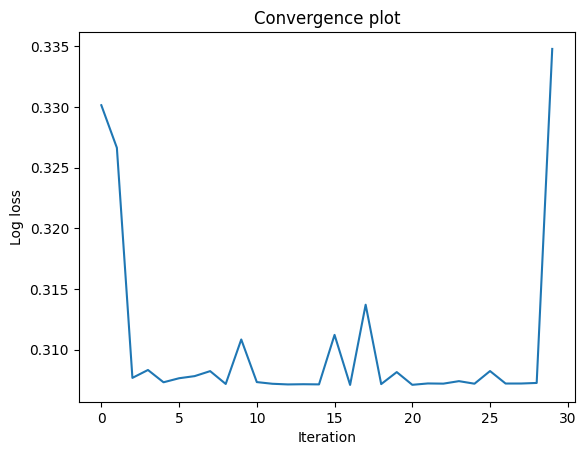

In [115]:
# let's see how the logloss looks over the trials
study.trials_dataframe()['value'].plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
# plt.ylim(0.3, 0.4)
plt.ylabel('Log loss')

In [116]:
# plot hyperparameter importances
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [117]:
# a more detailed view of how each parameter affects the objective score
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

Looks like out of all the models we've tried so far, `CatBoostClassifier` achieved the lowest log-loss at 0.3071. So we'll proceed with this model using the best parameters found to train our final model.

### 8.3. Final model - CatBoostClassifier

Now that we have the optimized parameters, let's train a CatBoostClassifier with 5-fold cross validation.

In [27]:
# capture the best parameters for the CatBoostClassifier here:
catboost_optimized_params = {'learning_rate': 0.011936869897820133,
 'n_estimators': 938,
 'depth': 7,
 'l2_leaf_reg': 5.515311166458147,
 'random_strength': 8.80636939848394,
 'bagging_temperature': 0.1427804858401882,
 'colsample_bylevel': 0.3017393168609862}

Let's perform cross-validation.

In [28]:
def catboost_cv(X, y, optimized_params, n_splits=5, random_state=101):
    # set up the parameters for the CatBoost classifier
    param = {
        'early_stopping_rounds': 100,
        'random_state': random_state,
        'logging_level': 'Silent',
        'eval_metric': 'Logloss',
        "border_count": 254,
        **optimized_params
    }

    model = CatBoostClassifier(**param)
    
    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    # Store log loss scores for each fold
    log_losses = []


    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Apply SMOTE to the training fold
        smote = SMOTE(sampling_strategy=0.3, random_state=random_state)  # Adjust the sampling strategy as needed
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        model.fit(X_train_resampled, y_train_resampled,
                  eval_set=(X_val_fold, y_val_fold),
                  verbose=0)
        
        y_pred_proba = model.predict_proba(X_val_fold)
        fold_log_loss = log_loss(y_val_fold, y_pred_proba)
        log_losses.append(fold_log_loss)
        
        print(f"Fold {fold} log loss: {fold_log_loss:.4f}")
    
    mean_log_loss = np.mean(log_losses)
    print(f"Cross-validated mean log loss: {mean_log_loss:.4f}")
    
    # model.fit(X, y, verbose=0)  # Fit the model on the entire dataset after cross-validation
    
    return model, log_losses

In [29]:
catboost, log_losses = catboost_cv(X_train.to_numpy(), y_train.to_numpy(), 
                                  catboost_optimized_params)

Fold 1 log loss: 0.3092
Fold 2 log loss: 0.3088
Fold 3 log loss: 0.3095
Fold 4 log loss: 0.3087
Fold 5 log loss: 0.3094
Cross-validated mean log loss: 0.3091


Let's also plot our logloss during training and evaluation

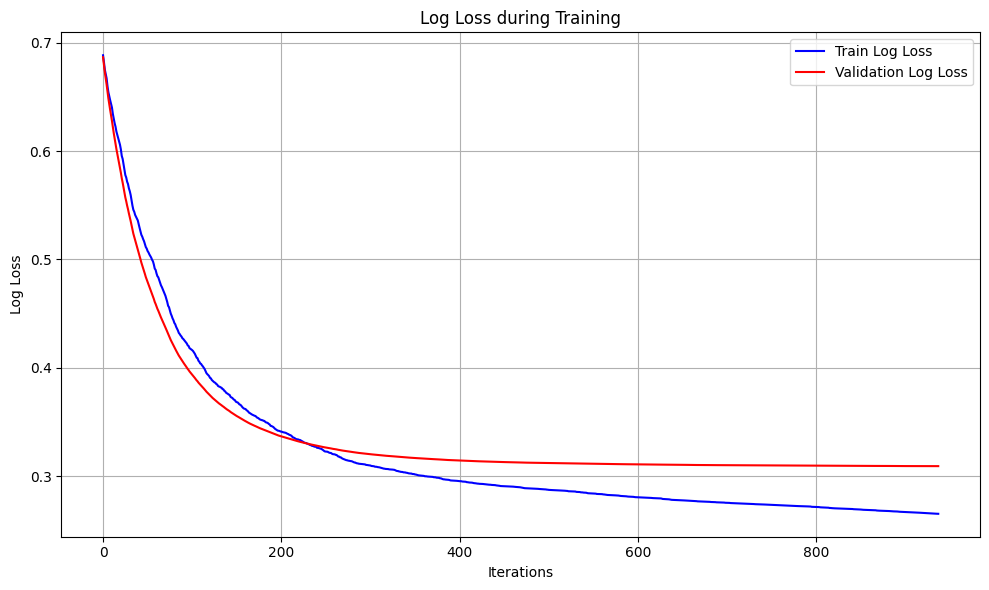

In [30]:
# get evaluation results
evals_results = catboost.get_evals_result()
logloss_train = evals_results['learn']['Logloss']
logloss_val = evals_results['validation']['Logloss']

# Plot log loss
plt.figure(figsize=(10, 6))
plt.plot(logloss_train, label='Train Log Loss', color='blue')
plt.plot(logloss_val, label='Validation Log Loss', color='red')
plt.title('Log Loss during Training')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Now we can fit the model on all our train dataset to get our final model.

In [31]:
catboost.fit(X_train.to_numpy(), y_train.to_numpy())

Let's evaluate our final model!

In [32]:
# make predictions on the train and test set
train_preds = catboost.predict_proba(X_train)[:, 1]
test_preds = catboost.predict_proba(X_test)[:, 1]

# calculate log loss on train and test set
train_log_loss = log_loss(y_train, train_preds)
test_log_loss = log_loss(y_test, test_preds)

print(f'Train set log-loss: {train_log_loss:.4f}')
print(f'Test set log-loss: {test_log_loss:.4f}')

Train set log-loss: 0.2901
Test set log-loss: 0.2995


Let's examine feature importance to see which features have high predictive power in our model

In [33]:
# capture feature importance from the model
feature_importance = catboost.get_feature_importance()
feature_names = X_train.columns

# create a dataframe 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

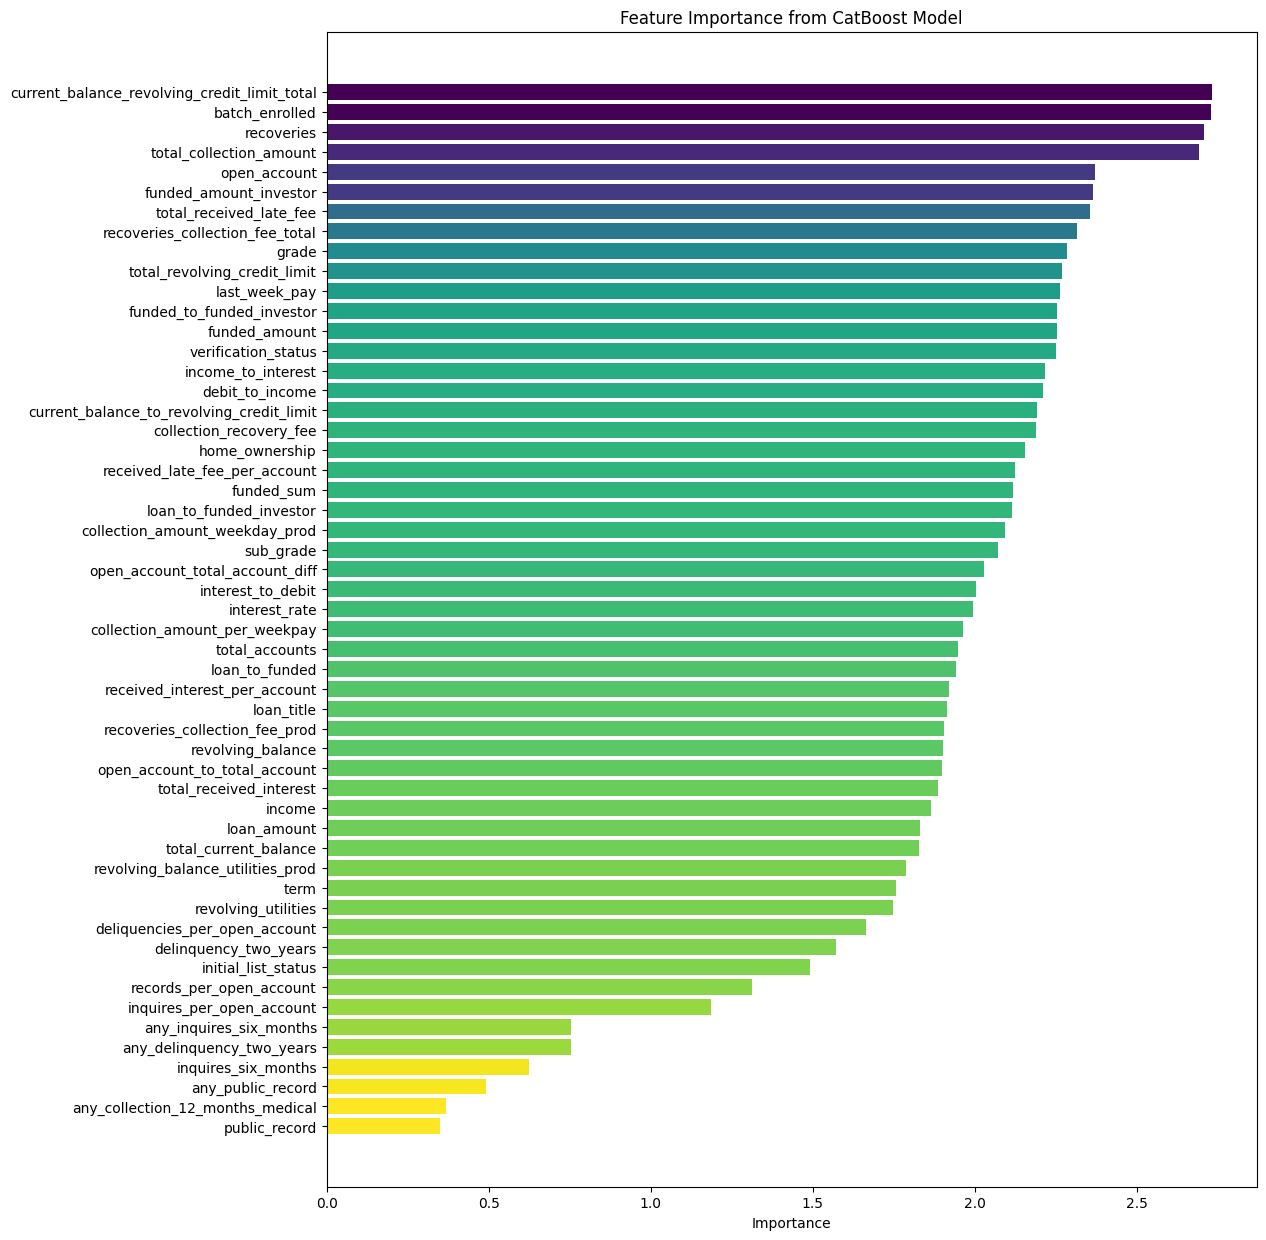

In [34]:
# Plot feature importance
# Create a color map based on importance values
norm = plt.Normalize(importance_df['Importance'].min(), importance_df['Importance'].max())
colors = plt.cm.viridis(norm(importance_df['Importance']))[::-1]  # Use a colormap like 'viridis'

plt.figure(figsize=(12, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance from CatBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

We can also compare the SHAP (Shapley Additive Explanations) values of our features. They provide insights into how each feature contributes to the predictions made by the model. 

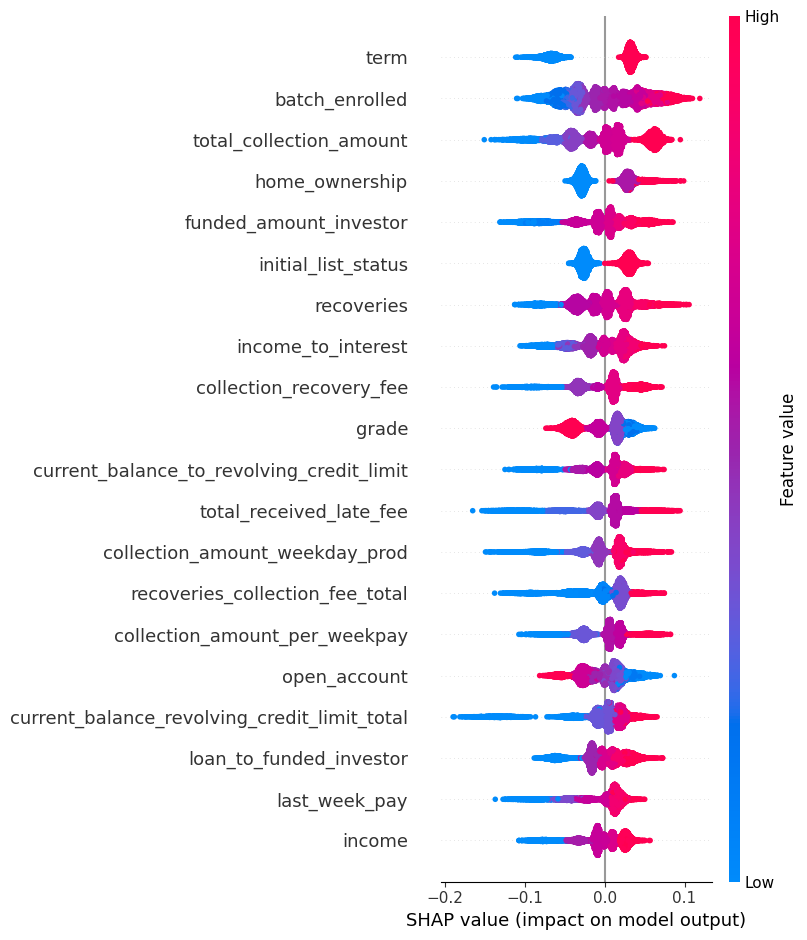

In [35]:
import shap

explainer = shap.Explainer(catboost)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [36]:
# save our model
import pickle

with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(catboost, file)